In [2]:
!pip install MeCab

In [4]:
!pip install wordcloud

In [6]:
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [textblob]1/2 [textblob]


In [14]:
!pip install janome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 2.8 MB/s eta 0:00:00a 0:00:01


日本語フォント 'Hiragino Sans' を設定しました。
=== 自然言語処理分析開始 ===
列名: ['Q1回答', 'Q2回答', 'Q3回答', '組織', '性別']
有効回答数: 300

--- 組織別分析 ---
 classification  improve  maintain
組織                               
NPO法人E                3        16
企業A                   0        21
企業B                   1        14
企業D                   2        24
団体C                   1        18

--- 性別別分析 ---
 classification  improve  maintain
性別                               
女性                    5        32
男性                    2        27
非回答                   0        34


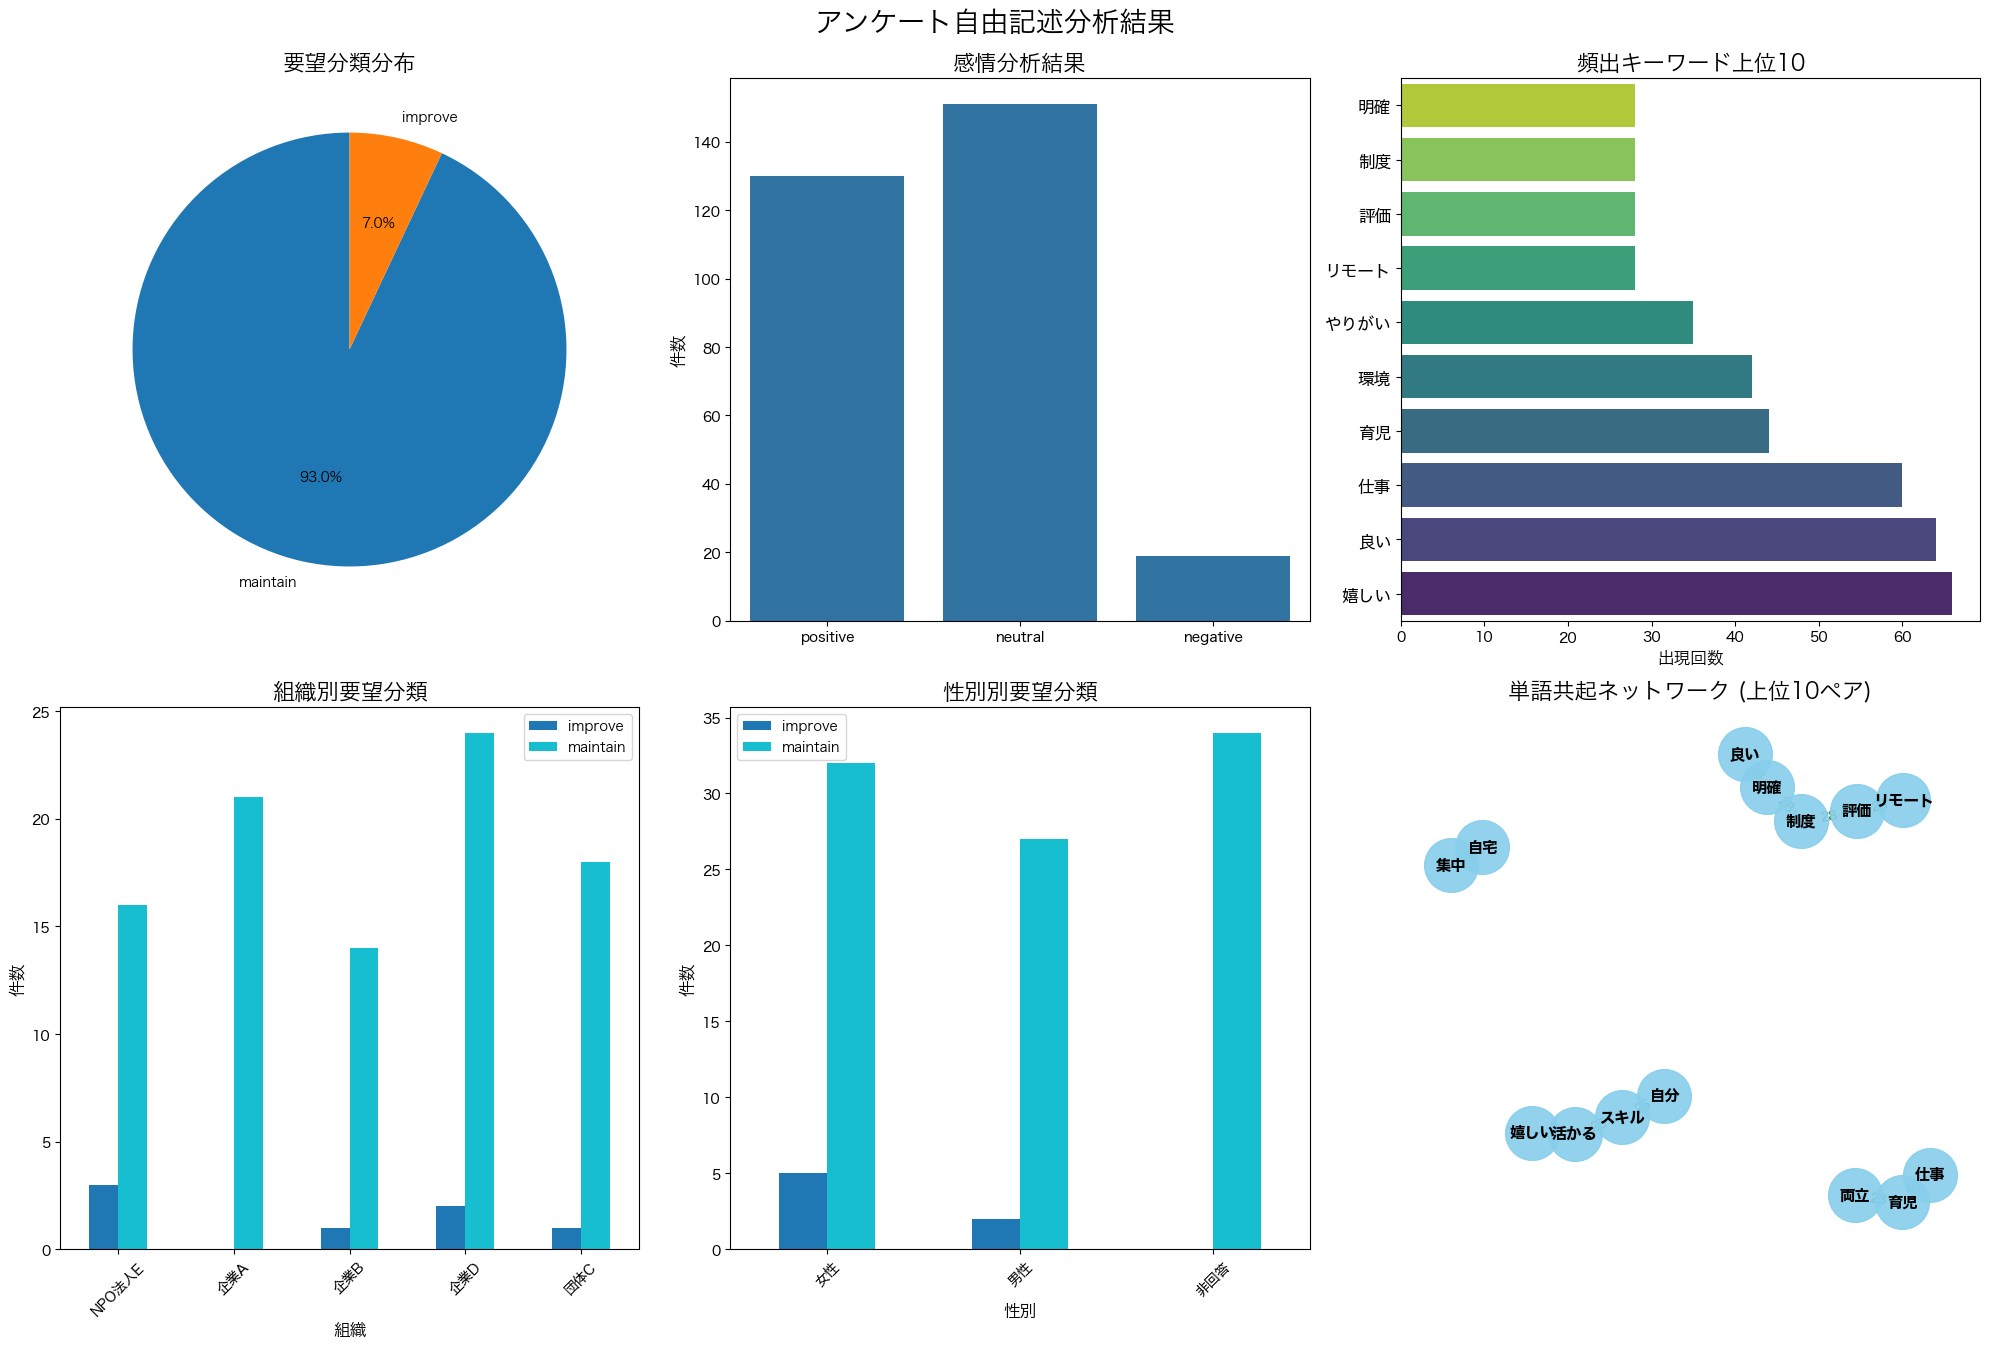

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import platform
import os
from matplotlib import font_manager, rcParams

# 日本語フォント設定
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/meiryo.ttc'
elif platform.system() == 'Darwin':
    font_path = '/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc'
else:
    font_path = '/usr/share/fonts/truetype/vlgothic/VL-Gothic-Regular.ttf'

if os.path.exists(font_path):
    font_prop = font_manager.FontProperties(fname=font_path)
    rcParams['font.family'] = font_prop.get_name()
    print(f"日本語フォント '{font_prop.get_name()}' を設定しました。")
else:
    font_prop = None
    print(f"警告: 指定された日本語フォント '{font_path}' が見つかりません。文字化けの可能性があります。")
    print("利用可能なフォントリスト:")
    font_files = font_manager.findSystemFonts(fontpaths=None)
    for f in font_files:
        if "japanese" in f.lower() or "gothic" in f.lower() or "meiryo" in f.lower() or "hiragino" in f.lower() or "noto" in f.lower():
            print(f"- {f}")

warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from janome.tokenizer import Tokenizer
import re
from itertools import combinations
import json

class SurveyNLPAnalyzer:
    def __init__(self, csv_file_path):
        self.df = pd.read_csv(csv_file_path)
        self.tokenizer = Tokenizer()
        self.processed_data = {}
        self.analysis_results = {}
        self.non_specific_patterns = [
            r'わからない', r'特になし', r'不明', r'なし',
            r'特に.*ない', r'よくわからない', r'^\s*$', r'ない'
        ]
        self.excluded_verbs = {'する', 'なる', 'いる', 'られる', '感じる', 'やすい', 'せる', 'ある', 'いう'}

    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text_str = str(text).lower()
        for pattern in self.non_specific_patterns:
            if re.search(pattern, text_str):
                return ""
        text_str = re.sub(r'[！!？?。．、，\s\t　]+', ' ', text_str)
        text_str = re.sub(r'[^\wぁ-んァ-ン一-龥a-zA-Z0-9]', '', text_str)
        return text_str.strip()

    def morphological_analysis(self, text):
        if not text:
            return []
        words = []
        for token in self.tokenizer.tokenize(text):
            base_form = token.base_form
            pos = token.part_of_speech.split(',')[0]
            
            if pos in ['名詞', '動詞', '形容詞']:
                if len(base_form) > 1 and base_form not in self.excluded_verbs:
                    words.append(base_form)
        return words

    def extract_keywords_tfidf(self, texts, top_n=10):
        processed_texts_for_vectorizer = [" ".join(self.morphological_analysis(text)) for text in texts if text]
        
        if not processed_texts_for_vectorizer:
            return []
        
        vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=1, max_df=0.8)
        tfidf_matrix = vectorizer.fit_transform(processed_texts_for_vectorizer)
        
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        keywords = [(feature_names[i], scores[i]) for i in range(len(feature_names))]
        return sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]

    def topic_modeling_lda(self, texts, n_topics=5):
        processed_texts_for_vectorizer = [" ".join(self.morphological_analysis(text)) for text in texts if text]

        if len(processed_texts_for_vectorizer) < 2:
            return []
        try:
            vectorizer = TfidfVectorizer(max_features=100, min_df=1, max_df=0.8)
            tfidf_matrix = vectorizer.fit_transform(processed_texts_for_vectorizer)
            
            feature_names = vectorizer.get_feature_names_out()
            lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda.fit(tfidf_matrix)
            topics = []
            for topic_idx, topic in enumerate(lda.components_):
                top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
                topics.append({'topic_id': topic_idx, 'words': top_words, 'weight': topic.max()})
            return topics
        except Exception as e:
            print(f"LDAエラー: {e}")
            return []

    def sentiment_analysis(self, text):
        if not text:
            return {'polarity': 0, 'sentiment': 'neutral'}
        positive_words = ['良い', 'よい', '嬉しい', 'うれしい', '楽しい', '満足', '助かる', '充実']
        negative_words = ['困る', '課題', '不満', '大変', '疲れる', '問題', 'ストレス']
        
        tokens = self.morphological_analysis(text)
        
        pos_count = sum(1 for word in tokens if word in positive_words)
        neg_count = sum(1 for word in tokens if word in negative_words)
        
        if pos_count > neg_count:
            return {'polarity': 1, 'sentiment': 'positive'}
        elif neg_count > pos_count:
            return {'polarity': -1, 'sentiment': 'negative'}
        else:
            return {'polarity': 0, 'sentiment': 'neutral'}

    def classify_request_type(self, text):
        if not text:
            return 'unknown'
        
        tokens = self.morphological_analysis(text)
        
        maintain_keywords = ['維持', '継続', '現状', '保持', '良い', 'よい', '満足', '嬉しい']
        enhance_keywords = ['強化', '向上', '発展', '拡大', '成長', '進歩', '発達', 'さらに']
        improve_keywords = ['改善', '課題', '問題', '困る', '難しい', '見直し', '変更', '修正']
        
        scores = {
            'maintain': sum(1 for word in tokens if word in maintain_keywords),
            'enhance': sum(1 for word in tokens if word in enhance_keywords),
            'improve': sum(1 for word in tokens if word in improve_keywords)
        }
        
        if all(score == 0 for score in scores.values()):
            return 'maintain'
            
        max_cat = max(scores, key=scores.get)
        return max_cat

    def collocation_analysis(self, texts):
        all_words = []
        for text in texts:
            if text:
                all_words.extend(self.morphological_analysis(text))
        
        if len(all_words) < 2:
            return []
            
        bigrams = [(all_words[i], all_words[i+1]) for i in range(len(all_words) - 1)]
        
        return Counter(bigrams).most_common(10)

    def create_network_graph(self, collocations):
        G = nx.Graph()
        if not collocations:
            return None
        for (w1, w2), count in collocations:
            G.add_edge(w1, w2, weight=count)
        return G if G.number_of_nodes() > 0 else None

    def analyze_all_data(self):
        print("=== 自然言語処理分析開始 ===")
        print(f"列名: {self.df.columns.tolist()}")

        all_raw_texts = []
        # Adjust column selection to handle cases where Q1, Q2, Q3 might not be the first 3 columns
        # Assuming Q1回答, Q2回答, Q3回答 are the columns containing free-text responses
        response_cols = [col for col in self.df.columns if '回答' in col]
        
        if not response_cols:
            print("警告: '回答'を含む列が見つかりませんでした。テキスト分析はスキップされます。")
            self.analysis_results = {} # Reset results if no response columns
            return self.analysis_results

        for col in response_cols:
            all_raw_texts.extend(self.df[col].tolist())

        processed_all_texts = [self.preprocess_text(text) for text in all_raw_texts]
        valid_all_texts = [text for text in processed_all_texts if text]

        print(f"有効回答数: {len(valid_all_texts)}")

        self.analysis_results['keywords'] = self.extract_keywords_tfidf(valid_all_texts)
        self.analysis_results['topics'] = self.topic_modeling_lda(valid_all_texts)
        
        sentiments = [self.sentiment_analysis(t) for t in valid_all_texts]
        self.analysis_results['sentiments'] = Counter([s['sentiment'] for s in sentiments])

        classifications = []
        for i, row in self.df.iterrows():
            combined_text_parts = []
            for col in response_cols:
                combined_text_parts.append(self.preprocess_text(row[col]))
            classifications.append(self.classify_request_type(" ".join(combined_text_parts).strip()))

        self.df['classification'] = classifications
        self.analysis_results['classifications'] = Counter(classifications)
        
        self.analysis_results['collocations'] = self.collocation_analysis(valid_all_texts)

        word_counts = Counter()
        for text in valid_all_texts:
            word_counts.update(self.morphological_analysis(text))
        self.analysis_results['top_words'] = word_counts.most_common(10)

        self.attribute_analysis()
        return self.analysis_results

    def attribute_analysis(self):
        # Check if '組織' and '性別' columns exist and are not empty
        has_org = '組織' in self.df.columns and not self.df['組織'].empty
        has_gender = '性別' in self.df.columns and not self.df['性別'].empty

        if has_org:
            org_analysis = self.df.groupby('組織')['classification'].value_counts().unstack(fill_value=0)
            self.analysis_results['org_analysis'] = org_analysis
            print("\n--- 組織別分析 ---\n", org_analysis)
        else:
            print("\n警告: '組織' 列が見つからないか、データが空です。組織別分析はスキップされます。")
            self.analysis_results['org_analysis'] = pd.DataFrame()

        if has_gender:
            gender_analysis = self.df.groupby('性別')['classification'].value_counts().unstack(fill_value=0)
            self.analysis_results['gender_analysis'] = gender_analysis
            print("\n--- 性別別分析 ---\n", gender_analysis)
        else:
            print("\n警告: '性別' 列が見つからないか、データが空です。性別別分析はスキップされます。")
            self.analysis_results['gender_analysis'] = pd.DataFrame()


    def visualize_results(self):
        # Ensure font_prop is available, otherwise fall back to default
        global font_prop
        if font_prop is None:
            print("警告: 日本語フォントが設定されていないため、一部のテキスト表示が正しくない可能性があります。")
            # Fallback to a generic font if specific font not found
            rcParams['font.family'] = ['sans-serif']
            # Create a dummy font_prop for consistency, if needed by methods directly
            # For simplicity, we'll let existing rcParams handle it where possible
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 14))

        # 1. 要望分類分布 (Pie Chart)
        classification_counts = self.analysis_results.get('classifications', Counter())
        if classification_counts and any(v > 0 for v in classification_counts.values()):
            labels = [k for k, v in classification_counts.items() if v > 0]
            sizes = [v for k, v in classification_counts.items() if v > 0]
            if font_prop:
                axes[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontproperties': font_prop})
                axes[0, 0].set_title('要望分類分布', fontproperties=font_prop, fontsize=16)
            else:
                axes[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                axes[0, 0].set_title('要望分類分布', fontsize=16)
        else:
            axes[0, 0].axis('off')
            if font_prop:
                axes[0, 0].set_title('要望分類データなし', fontproperties=font_prop, fontsize=16)
            else:
                axes[0, 0].set_title('要望分類データなし', fontsize=16)

        # 2. 感情分析結果 (Bar Chart)
        sentiment_counts = self.analysis_results.get('sentiments', Counter())
        if sentiment_counts and any(sentiment_counts.values()):
            sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), ax=axes[0, 1])
            if font_prop:
                axes[0, 1].set_title('感情分析結果', fontproperties=font_prop, fontsize=16)
                axes[0, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=12)
                # Removed fontproperties from tick_params. Use labelsize and fontfamily if needed.
                axes[0, 1].tick_params(axis='x', labelsize=10) 
            else:
                axes[0, 1].set_title('感情分析結果', fontsize=16)
                axes[0, 1].set_ylabel('件数', fontsize=12)
                axes[0, 1].tick_params(axis='x', labelsize=10)
            axes[0, 1].tick_params(axis='y', labelsize=10)
        else:
            axes[0, 1].axis('off')
            if font_prop:
                axes[0, 1].set_title('感情分析データなし', fontproperties=font_prop, fontsize=16)
            else:
                axes[0, 1].set_title('感情分析データなし', fontsize=16)

        # 3. 頻出キーワード上位10 (Horizontal Bar Chart)
        top_words = self.analysis_results.get('top_words', [])
        if top_words:
            words, counts = zip(*top_words)
            sns.barplot(x=list(counts), y=list(words), ax=axes[0, 2], orient='h', palette='viridis')
            if font_prop:
                axes[0, 2].set_title('頻出キーワード上位10', fontproperties=font_prop, fontsize=16)
                axes[0, 2].set_xlabel('出現回数', fontproperties=font_prop, fontsize=12)
                # Removed fontproperties from tick_params. Use labelsize and fontfamily if needed.
                axes[0, 2].tick_params(axis='y', labelsize=12) 
            else:
                axes[0, 2].set_title('頻出キーワード上位10', fontsize=16)
                axes[0, 2].set_xlabel('出現回数', fontsize=12)
                axes[0, 2].tick_params(axis='y', labelsize=12)
            axes[0, 2].tick_params(axis='x', labelsize=10)
            axes[0, 2].invert_yaxis()
        else:
            axes[0, 2].axis('off')
            if font_prop:
                axes[0, 2].set_title('頻出キーワードなし', fontproperties=font_prop, fontsize=16)
            else:
                axes[0, 2].set_title('頻出キーワードなし', fontsize=16)

        # 4. 組織別要望分類 (Bar Chart)
        org_analysis = self.analysis_results.get('org_analysis', pd.DataFrame())
        if not org_analysis.empty and not org_analysis.sum().sum() == 0:
            org_analysis.plot(kind='bar', ax=axes[1, 0], colormap='tab10')
            if font_prop:
                axes[1, 0].set_title('組織別要望分類', fontproperties=font_prop, fontsize=16)
                axes[1, 0].set_ylabel('件数', fontproperties=font_prop, fontsize=12)
                axes[1, 0].set_xlabel('組織', fontproperties=font_prop, fontsize=12)
                # Removed fontproperties from tick_params. Use labelsize and fontfamily if needed.
                axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10) 
                axes[1, 0].legend(prop=font_prop, fontsize=10)
            else:
                axes[1, 0].set_title('組織別要望分類', fontsize=16)
                axes[1, 0].set_ylabel('件数', fontsize=12)
                axes[1, 0].set_xlabel('組織', fontsize=12)
                axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)
                axes[1, 0].legend(fontsize=10)
            axes[1, 0].tick_params(axis='y', labelsize=10)
        else:
            axes[1, 0].axis('off')
            if font_prop:
                axes[1, 0].set_title('組織別分類データなし', fontproperties=font_prop, fontsize=16)
            else:
                axes[1, 0].set_title('組織別分類データなし', fontsize=16)

        # 5. 性別別要望分類 (Bar Chart)
        gender_analysis = self.analysis_results.get('gender_analysis', pd.DataFrame())
        if not gender_analysis.empty and not gender_analysis.sum().sum() == 0:
            gender_analysis.plot(kind='bar', ax=axes[1, 1], colormap='tab10')
            if font_prop:
                axes[1, 1].set_title('性別別要望分類', fontproperties=font_prop, fontsize=16)
                axes[1, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=12)
                axes[1, 1].set_xlabel('性別', fontproperties=font_prop, fontsize=12)
                # Removed fontproperties from tick_params. Use labelsize and fontfamily if needed.
                axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10) 
                axes[1, 1].legend(prop=font_prop, fontsize=10)
            else:
                axes[1, 1].set_title('性別別要望分類', fontsize=16)
                axes[1, 1].set_ylabel('件数', fontsize=12)
                axes[1, 1].set_xlabel('性別', fontsize=12)
                axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)
                axes[1, 1].legend(fontsize=10)
            axes[1, 1].tick_params(axis='y', labelsize=10)
        else:
            axes[1, 1].axis('off')
            if font_prop:
                axes[1, 1].set_title('性別分類データなし', fontproperties=font_prop, fontsize=16)
            else:
                axes[1, 1].set_title('性別分類データなし', fontsize=16)

        # 6. 単語共起ネットワーク (Network Graph)
        collocations = self.analysis_results.get('collocations', [])
        G = self.create_network_graph(collocations[:10])
        if G:
            pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)
            nx.draw_networkx_nodes(G, pos, ax=axes[1, 2], node_color='skyblue', node_size=1500, alpha=0.9)
            nx.draw_networkx_edges(G, pos, ax=axes[1, 2], width=1.5, alpha=0.7, edge_color='gray')
            
            edge_labels = nx.get_edge_attributes(G, 'weight')
            if font_prop:
                nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[1, 2], font_size=9, font_color='darkgreen', font_family=font_prop.get_name())
                nx.draw_networkx_labels(G, pos, ax=axes[1, 2], font_size=11, font_weight='bold', font_color='black', font_family=font_prop.get_name())
                axes[1, 2].set_title('単語共起ネットワーク (上位10ペア)', fontproperties=font_prop, fontsize=16)
            else:
                nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[1, 2], font_size=9, font_color='darkgreen')
                nx.draw_networkx_labels(G, pos, ax=axes[1, 2], font_size=11, font_weight='bold', font_color='black')
                axes[1, 2].set_title('単語共起ネットワーク (上位10ペア)', fontsize=16)
            axes[1, 2].axis('off')
        else:
            axes[1, 2].axis('off')
            if font_prop:
                axes[1, 2].set_title('共起データなし', fontproperties=font_prop, fontsize=16)
            else:
                axes[1, 2].set_title('共起データなし', fontsize=16)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        if font_prop:
            plt.suptitle('アンケート自由記述分析結果', fontproperties=font_prop, fontsize=20, y=0.99)
        else:
            plt.suptitle('アンケート自由記述分析結果', fontsize=20, y=0.99)
        plt.savefig('survey_analysis_results_updated.png', dpi=300, bbox_inches='tight')
        plt.show()

def main():
    analyzer = SurveyNLPAnalyzer('random_survey_output_bom.csv')
    analyzer.analyze_all_data()
    analyzer.visualize_results()

if __name__ == '__main__':
    main()

📌 上位頻出単語（Top 20）:
嬉しい: 66
良い: 64
仕事: 60
育児: 44
環境: 42
やりがい: 35
リモート: 28
評価: 28
制度: 28
明確: 28
✅ 分析結果を 'analyzed_survey_output.csv' に保存しました。


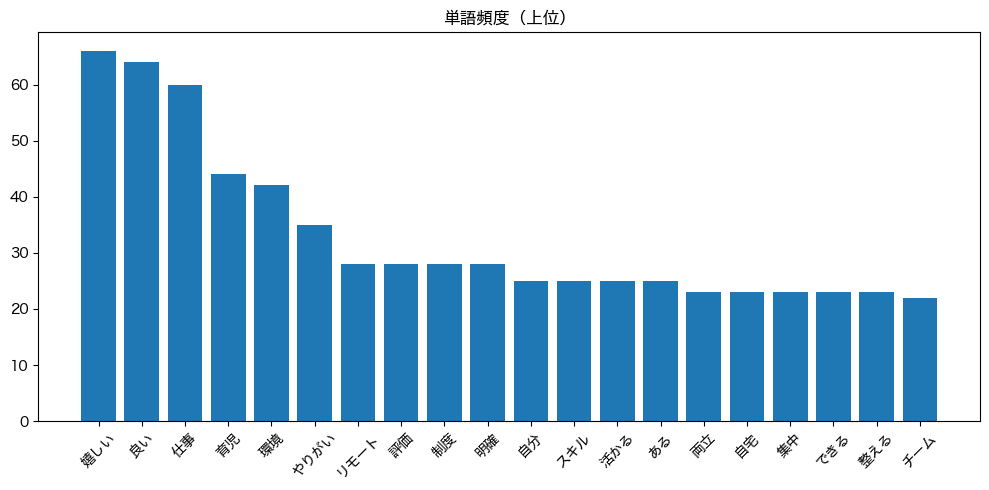

In [34]:
import pandas as pd
import re
from janome.tokenizer import Tokenizer
from collections import Counter
import matplotlib.pyplot as plt

# ファイル読み込み
file_path = 'random_survey_output_bom.csv'  # ファイル名を適宜変更してください
df = pd.read_csv(file_path)

# Janomeトークナイザー
tokenizer = Tokenizer()

# 除外対象パターン
non_specific = re.compile(r"^\s*$|わからない|特になし|なし|ない|不明")

# 形態素解析（名詞・動詞・形容詞を抽出）
def tokenize(text):
    if pd.isna(text) or non_specific.match(text):
        return []
    text = re.sub(r'[^\wぁ-んァ-ン一-龥]', '', str(text))
    tokens = []
    excluded_verbs = {'する', 'なる', 'いる', 'られる', '感じる', 'やすい', 'せる', ''}
    for token in tokenizer.tokenize(text):
        base = token.base_form
        pos = token.part_of_speech.split(',')[0]
        # 名詞・形容詞・動詞のみで、以下を除外：
        # - 意味の薄い動詞
        # - 1文字の語（意味が薄い）
        if pos in ['名詞', '動詞', '形容詞']:
            if base in excluded_verbs or len(base) <= 1:
                continue
            tokens.append(base)
    return tokens

# トークン化処理
for col in ['Q1回答', 'Q2回答', 'Q3回答']:
    df[f'{col}_tokens'] = df[col].apply(tokenize)

# 全トークンの収集
all_tokens = df['Q1回答_tokens'] + df['Q2回答_tokens'] + df['Q3回答_tokens']
all_flat_tokens = [token for sublist in all_tokens for token in sublist]

# 頻度集計
freq = Counter(all_flat_tokens)
print("📌 上位頻出単語（Top 20）:")
for word, count in freq.most_common(10):
    print(f"{word}: {count}")

# 感情キーワード例（カスタマイズ可能）
positive_words = {'嬉しい', '良い', 'やりがい', '楽しい', '満足', '助かる', '充実'}
negative_words = {'困る', '課題', '不満', '大変', '疲れる', '問題', 'ストレス'}

def judge_sentiment(tokens):
    pos = any(token in positive_words for token in tokens)
    neg = any(token in negative_words for token in tokens)
    if pos and not neg:
        return 'ポジティブ'
    elif neg and not pos:
        return 'ネガティブ'
    elif pos and neg:
        return 'ミックス'
    else:
        return '中立'

# 感情判定を各列に適用
for col in ['Q1回答_tokens', 'Q2回答_tokens', 'Q3回答_tokens']:
    df[f'{col}_sentiment'] = df[col].apply(judge_sentiment)

# 保存（必要であれば）
df.to_csv('analyzed_survey_output.csv', index=False)
print("✅ 分析結果を 'analyzed_survey_output.csv' に保存しました。")

# （任意）単語頻度の棒グラフを表示
def plot_top_words(counter, top_n=20):
    top_items = counter.most_common(top_n)
    words, counts = zip(*top_items)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title("単語頻度（上位）")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 実行（任意）
plot_top_words(freq)

In [1]:
!pip install janome

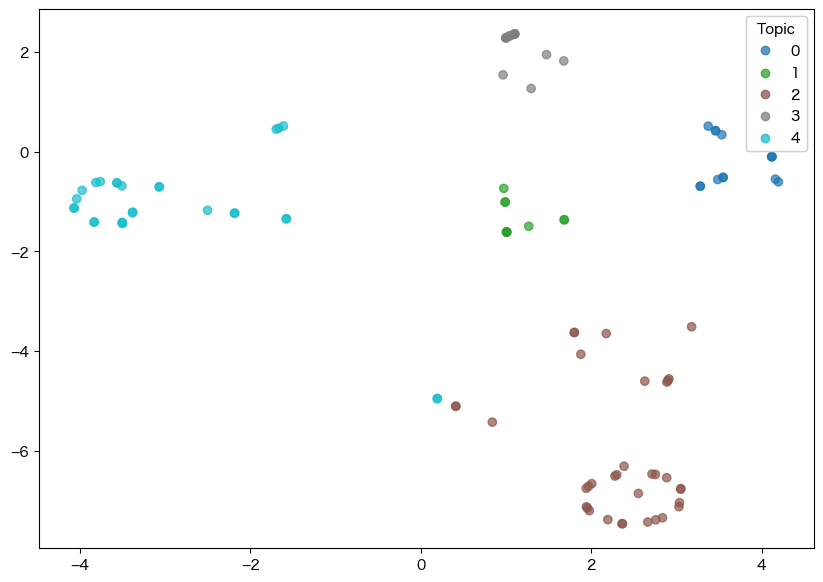

In [37]:
import pandas as pd
import re
from janome.tokenizer import Tokenizer
from gensim import corpora, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# --- データ準備
df = pd.read_csv("random_survey_output_bom.csv")
columns = ['Q1回答', 'Q2回答', 'Q3回答']
df['text'] = df[columns].fillna('').agg(' '.join, axis=1)

# --- トークナイズ関数
tokenizer = Tokenizer()
def tokenize(text):
    text = re.sub(r'[^\wぁ-んァ-ン一-龥]', '', text)
    tokens = []
    for token in tokenizer.tokenize(text):
        base = token.base_form
        pos = token.part_of_speech.split(',')[0]
        if pos in ['名詞', '動詞', '形容詞'] and len(base) > 1:
            tokens.append(base)
    return tokens

# --- トークン化と辞書作成
df['tokens'] = df['text'].apply(tokenize)
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# --- LDAモデリング
NUM_TOPICS = 5
lda_model = models.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=10, random_state=42)

# --- 文書ごとのトピック分布を取得
topic_distributions = [lda_model.get_document_topics(doc, minimum_probability=0.0) for doc in corpus]
topic_vectors = np.array([[score for _, score in doc] for doc in topic_distributions])

# --- 次元削減（t-SNE）
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(topic_vectors)

# --- 可視化（マウスアノテーション付き）
fig, ax = plt.subplots(figsize=(10, 7))
sc = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=np.argmax(topic_vectors, axis=1), cmap='tab10', alpha=0.7)

# --- トピックの色凡例
legend = ax.legend(*sc.legend_elements(), title="Topic")
ax.add_artist(legend)

# ... LDAモデリングとt-SNEのコード ...
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(topic_vectors)

# --- データをプロット用に整形 ---
# トピック番号と元のテキストをt-SNEの結果に結合
plot_df = pd.DataFrame(tsne_results, columns=['x', 'y'])
plot_df['topic'] = np.argmax(topic_vectors, axis=1)
plot_df['text'] = df['text'] # ホバー表示用のテキスト
plot_df['id'] = df.index # ホバー表示用のID

# --- 📊 Plotlyでインタラクティブ可視化 ---
import plotly.express as px

fig = px.scatter(
    plot_df,
    x='x',
    y='y',
    color='topic',                   # トピック番号で色分け
    custom_data=['id', 'text'],      # ホバーで使いたいデータを指定
    title="LDAトピック空間（t-SNEによる可視化）"
)

# ホバーで表示するテキストのテンプレートを定義
# <br>は改行、<b>は太字。%{custom_data[0]}がid, %{custom_data[1]}がtextに対応
hovertemplate = """
<b>ID: %{custom_data[0]}</b><br>
Topic: %{y:.2f}<br>
Text: %{custom_data[1]|<br>|100} ...<br>
"""
# |<br>|100 は100文字ごとに<br>で改行する指定（Plotlyの機能）

fig.update_traces(hovertemplate=hovertemplate)
fig.update_layout(
    xaxis_title="t-SNE 1",
    yaxis_title="t-SNE 2",
    legend_title_text='Topic'
)

fig.show()

日本語フォント 'Hiragino Sans' を設定しました。
=== 自然言語処理分析開始 ===
列名: ['Q1回答', 'Q2回答', 'Q3回答', '組織', '性別']
全体での有効回答数: 300

--- 組織別要望分類 ---
 classification  improve  maintain
組織                               
NPO法人E                3        16
企業A                   0        21
企業B                   1        14
企業D                   2        24
団体C                   1        18

--- 性別別要望分類 ---
 classification  improve  maintain
性別                               
女性                    5        32
男性                    2        27
非回答                   0        34

--- 設問 'Q1回答' の分析開始 ---
設問 'Q1回答' の有効回答数: 100

--- 設問 'Q2回答' の分析開始 ---
設問 'Q2回答' の有効回答数: 100

--- 設問 'Q3回答' の分析開始 ---
設問 'Q3回答' の有効回答数: 100


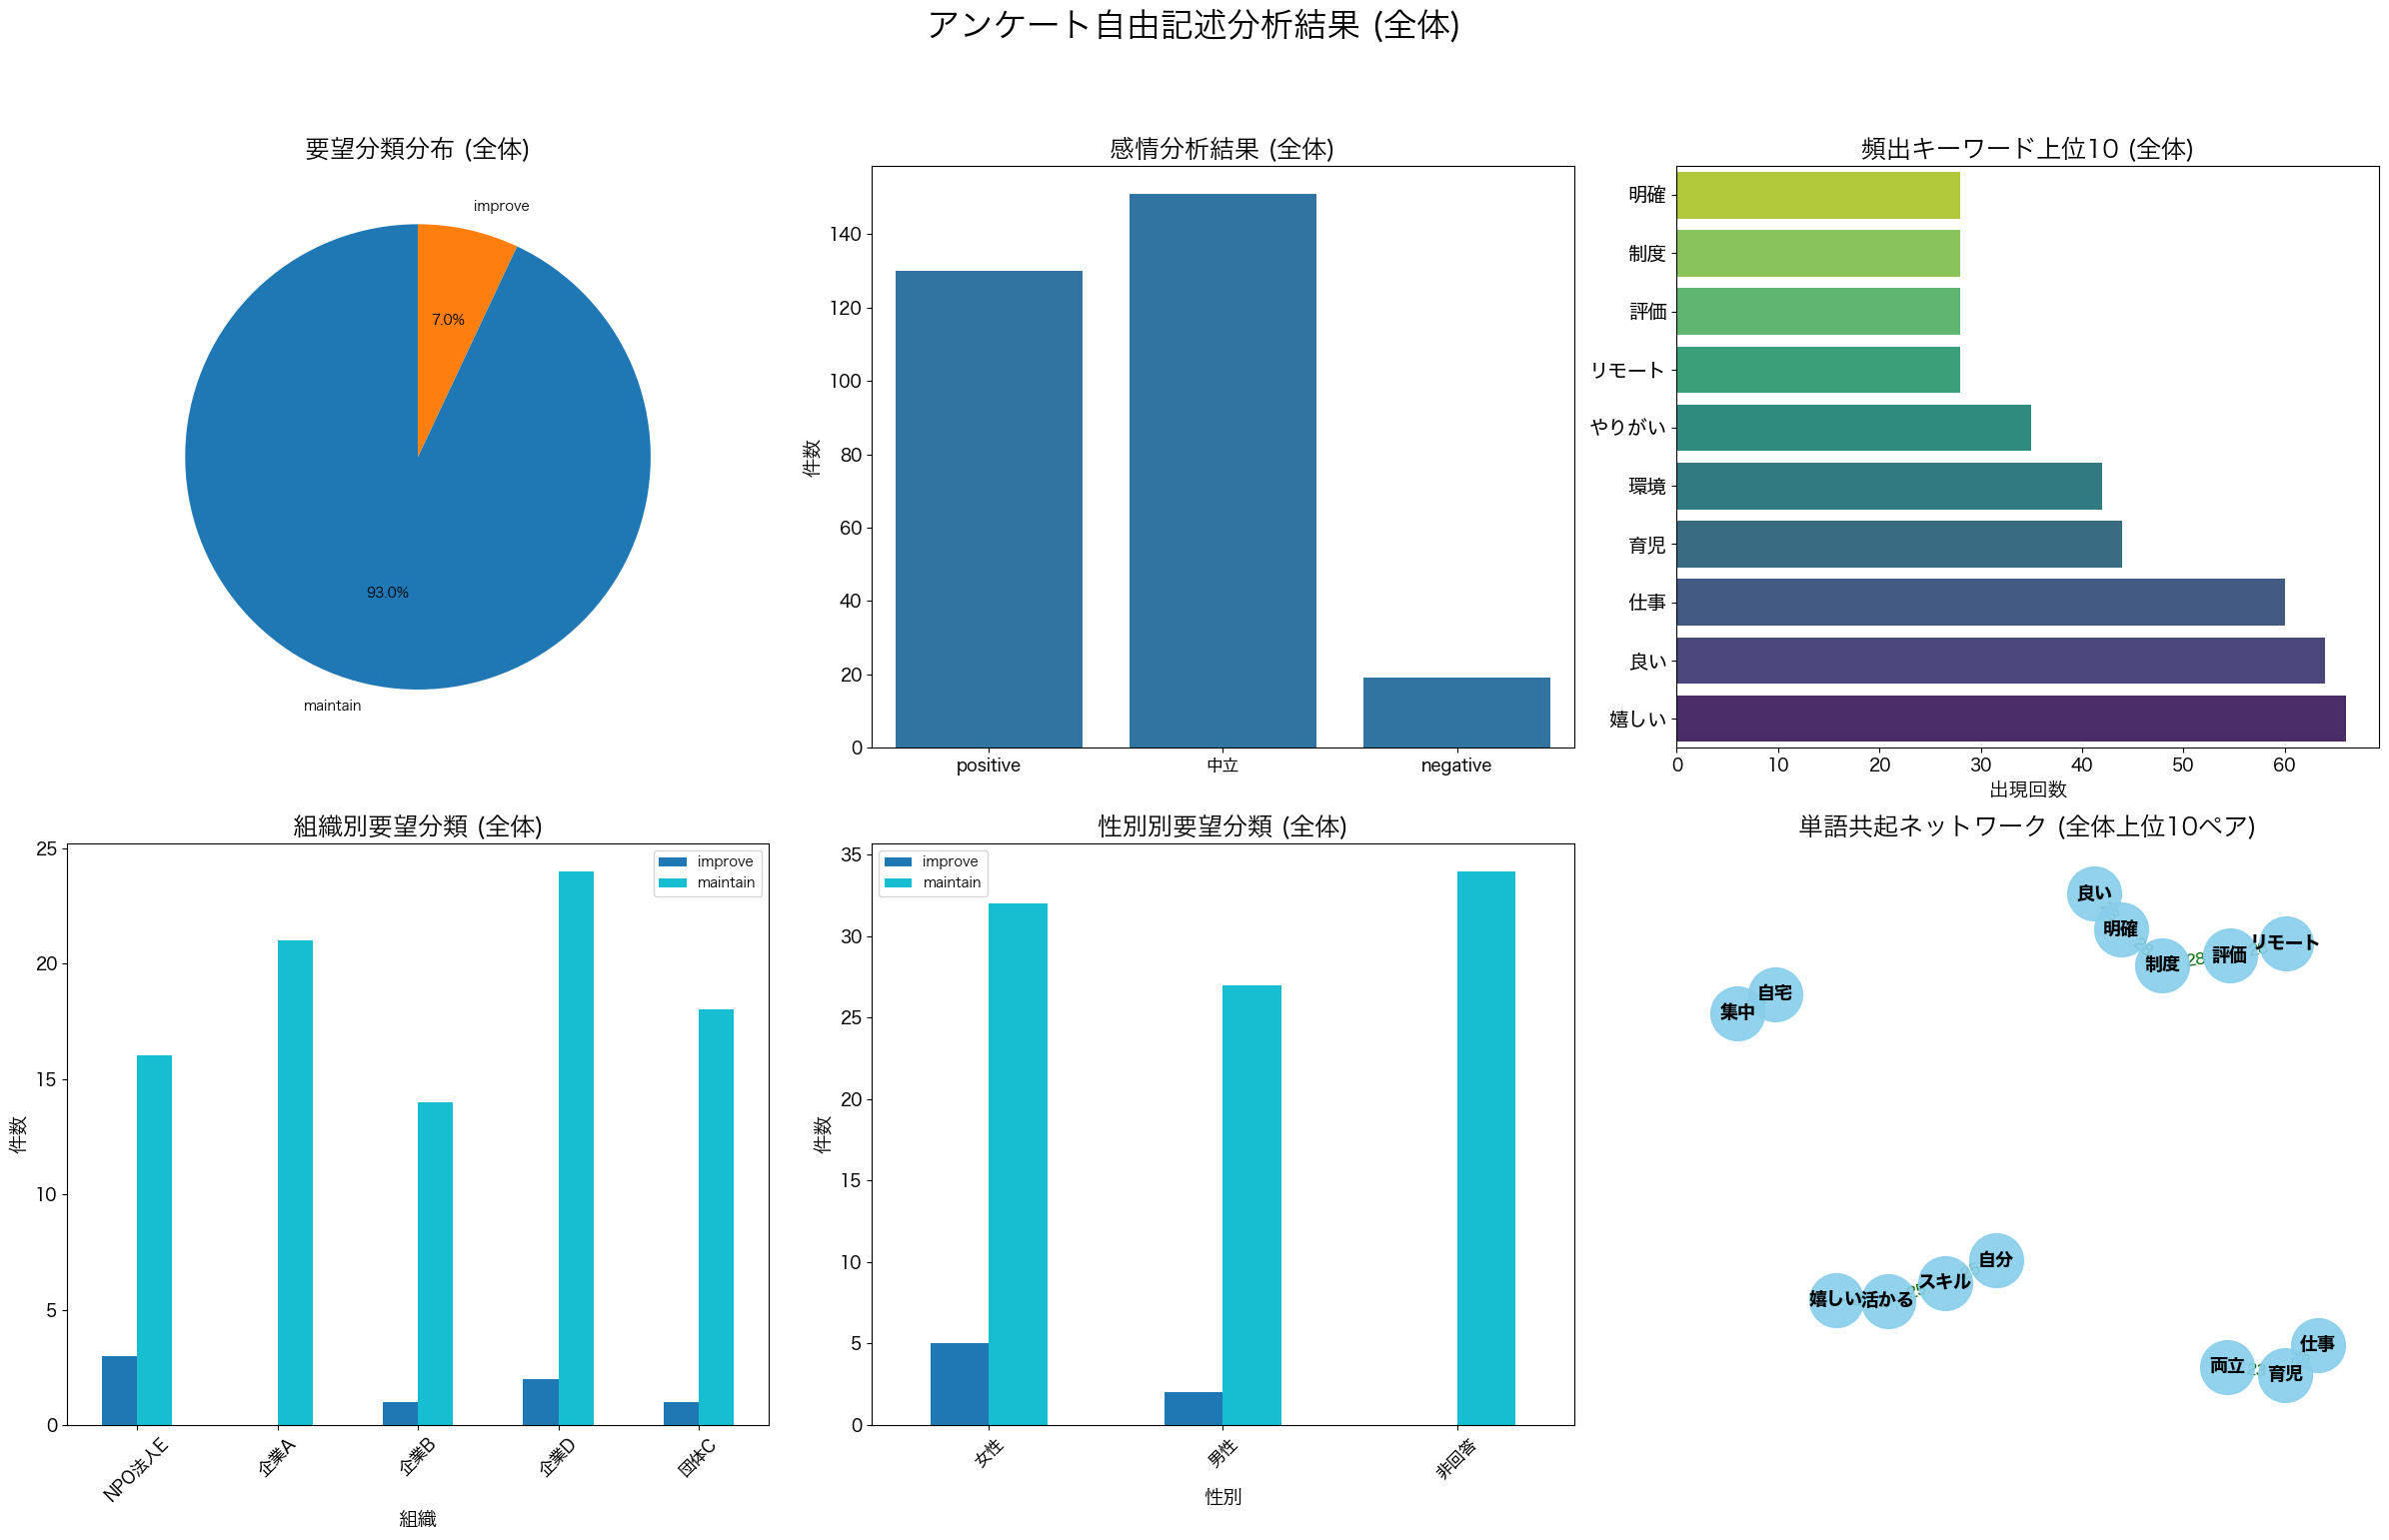

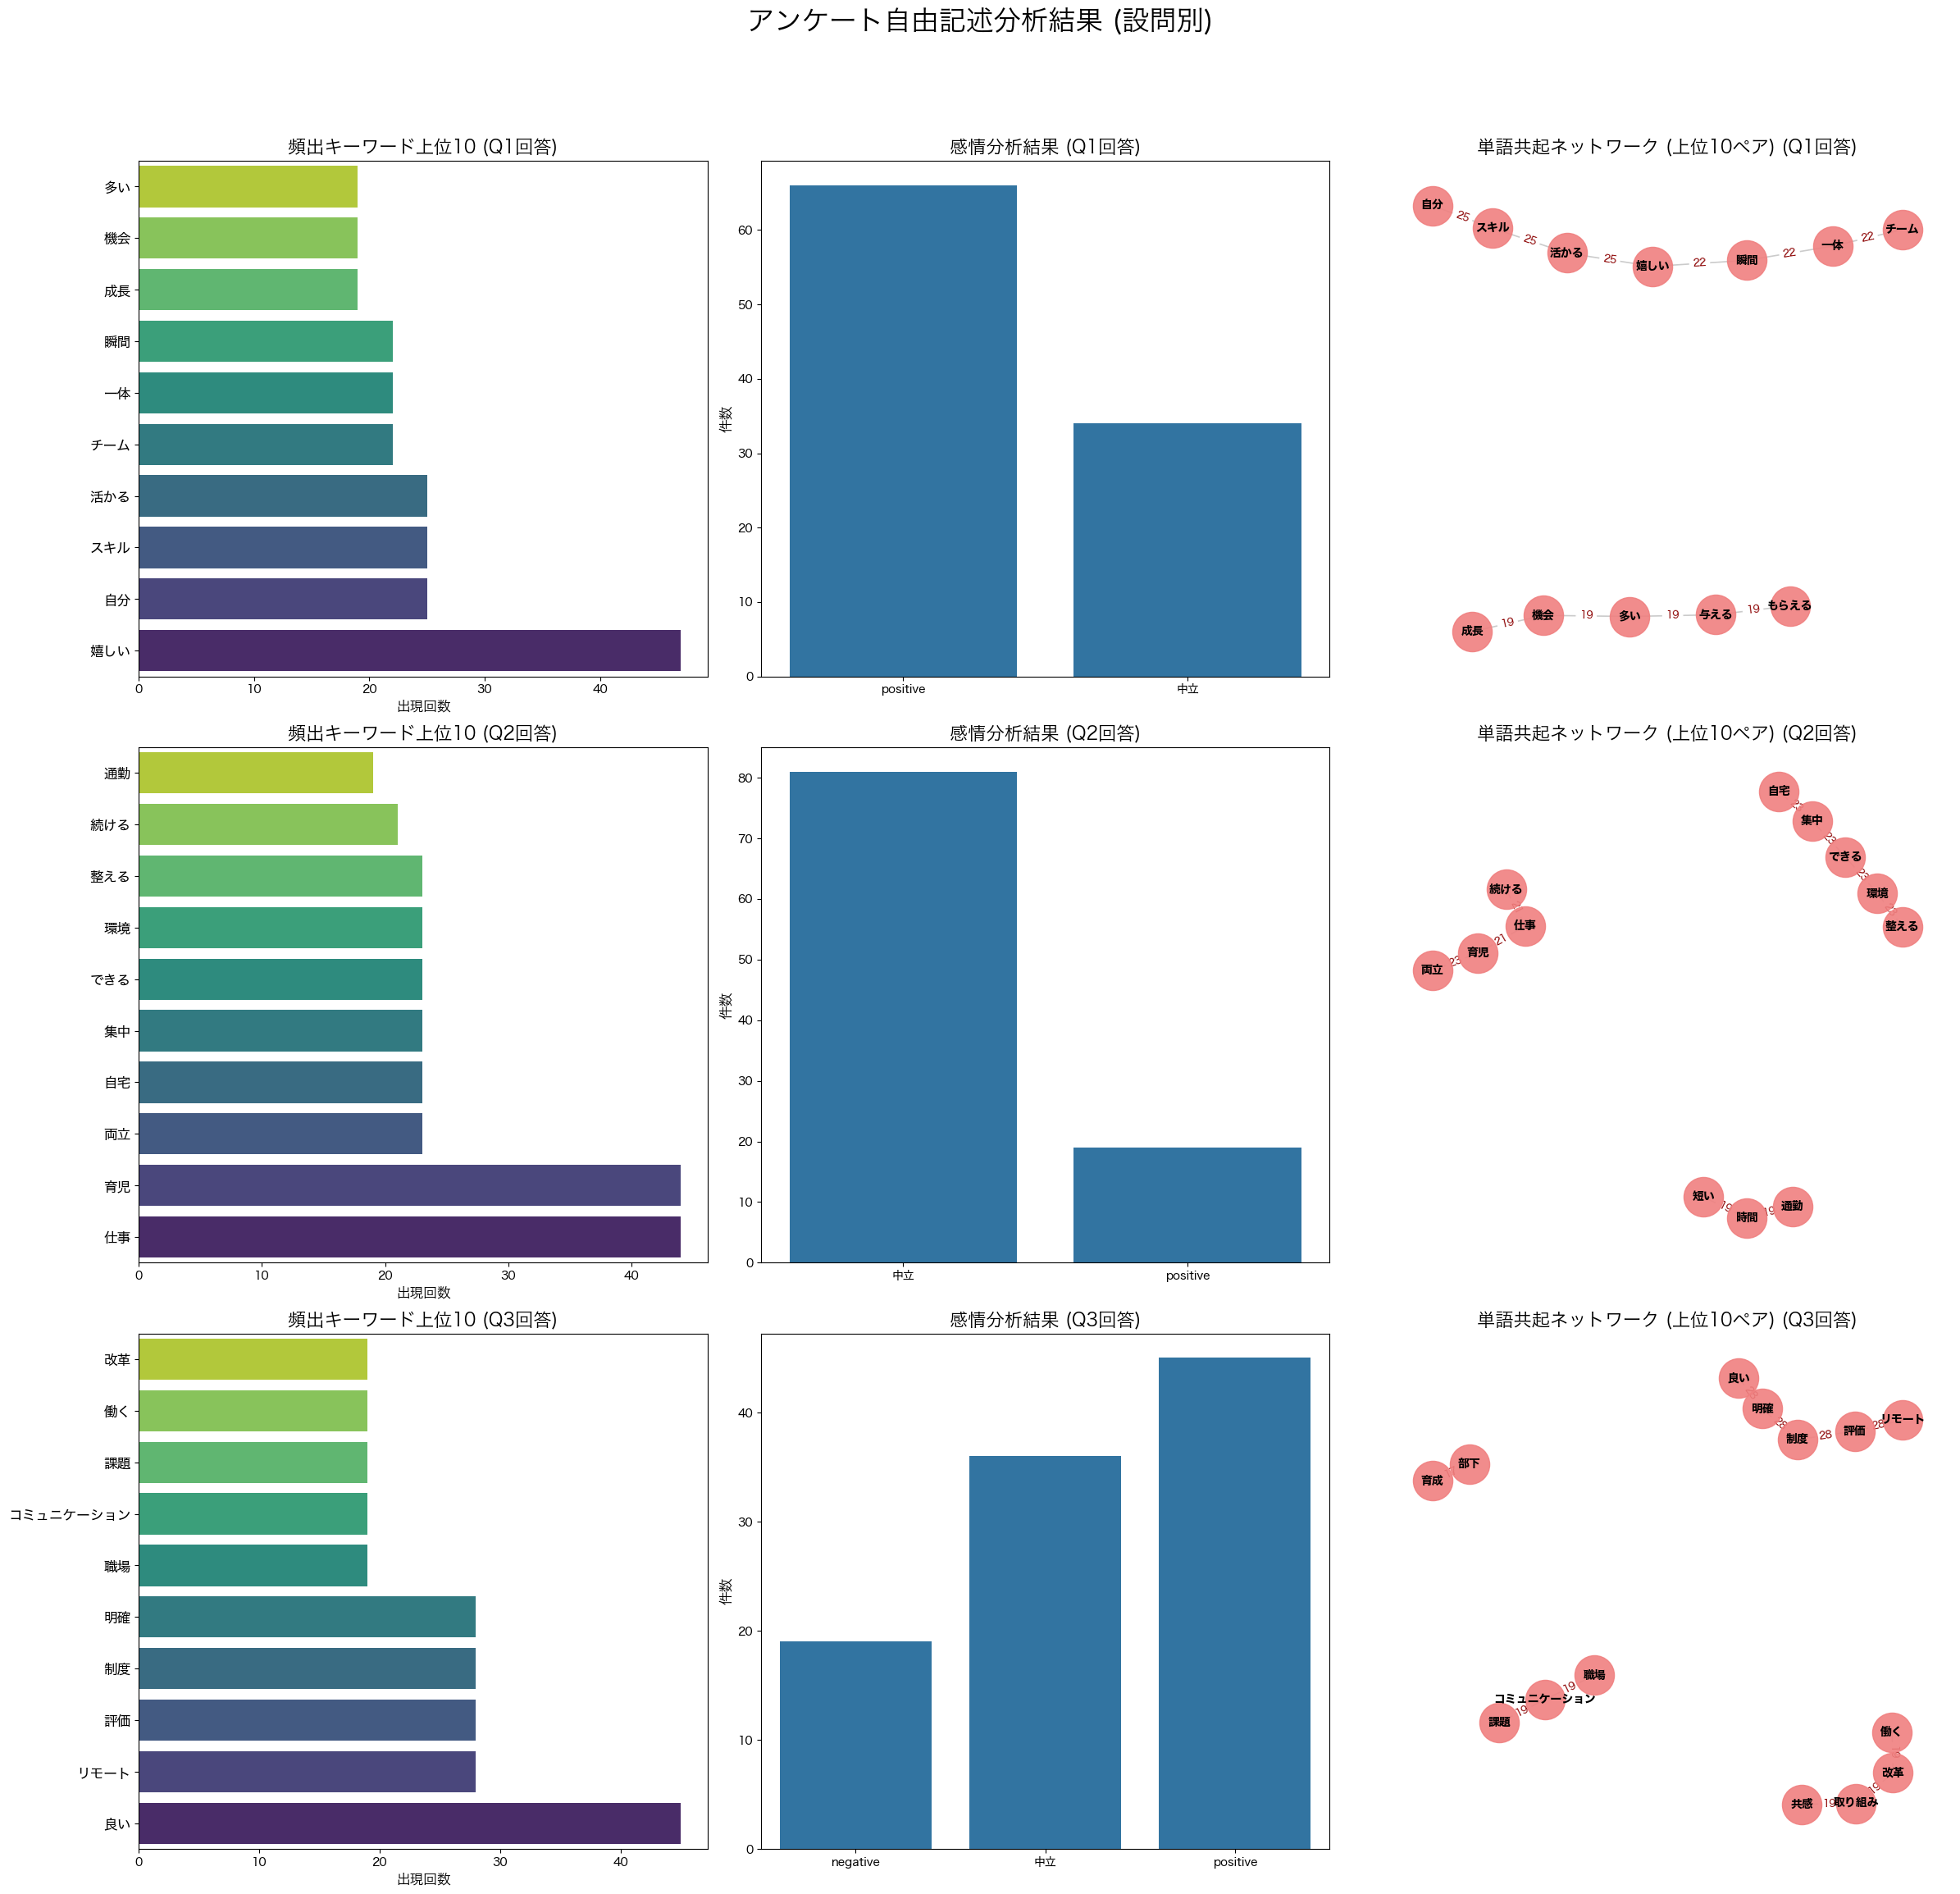

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import platform
import os
from matplotlib import font_manager, rcParams

# 日本語フォント設定
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/meiryo.ttc'
elif platform.system() == 'Darwin':
    font_path = '/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc'
else:
    # Linux (例: Ubuntuの場合) のフォントパス
    font_path = '/usr/share/fonts/truetype/vlgothic/VL-Gothic-Regular.ttf'
    # 他のLinuxディストリビューションの場合、適宜変更してください
    # 例: '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'

if os.path.exists(font_path):
    font_prop = font_manager.FontProperties(fname=font_path)
    rcParams['font.family'] = font_prop.get_name()
    print(f"日本語フォント '{font_prop.get_name()}' を設定しました。")
else:
    font_prop = None
    print(f"警告: 指定された日本語フォント '{font_path}' が見つかりません。文字化けの可能性があります。")
    print("利用可能なフォントリスト:")
    font_files = font_manager.findSystemFonts(fontpaths=None)
    for f in font_files:
        if "japanese" in f.lower() or "gothic" in f.lower() or "meiryo" in f.lower() or "hiragino" in f.lower() or "noto" in f.lower():
            print(f"- {f}")


warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from janome.tokenizer import Tokenizer
import re
from itertools import combinations
import json

class SurveyNLPAnalyzer:
    def __init__(self, csv_file_path):
        self.df = pd.read_csv(csv_file_path)
        self.tokenizer = Tokenizer()
        self.processed_data = {}
        self.analysis_results = {}
        # 設問列の特定 (例: Q1回答, Q2回答, Q3回答)
        self.question_cols = [col for col in self.df.columns if re.match(r'Q\d+回答', col)]

        self.non_specific_patterns = [
            r'わからない', r'特になし', r'不明', r'なし',
            r'特に.*ない', r'よくわからない', r'^\s*$', r'ない'
        ]
        self.excluded_verbs = {'する', 'なる', 'いる', 'られる', '感じる', 'やすい', 'せる', 'ある', 'いう'}

    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text_str = str(text).lower()
        for pattern in self.non_specific_patterns:
            if re.search(pattern, text_str):
                return ""
        text_str = re.sub(r'[！!？?。．、，\s\t　]+', ' ', text_str)
        text_str = re.sub(r'[^\wぁ-んァ-ン一-龥a-zA-Z0-9]', '', text_str)
        return text_str.strip()

    def morphological_analysis(self, text):
        if not text:
            return []
        words = []
        for token in self.tokenizer.tokenize(text):
            base_form = token.base_form
            pos = token.part_of_speech.split(',')[0]
            
            if pos in ['名詞', '動詞', '形容詞']:
                if len(base_form) > 1 and base_form not in self.excluded_verbs:
                    words.append(base_form)
        return words

    def extract_keywords_tfidf(self, texts, top_n=10):
        processed_texts_for_vectorizer = [" ".join(self.morphological_analysis(text)) for text in texts if text]
        
        if not processed_texts_for_vectorizer:
            return []
        
        vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=1, max_df=0.8)
        tfidf_matrix = vectorizer.fit_transform(processed_texts_for_vectorizer)
        
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        keywords = [(feature_names[i], scores[i]) for i in range(len(feature_names))]
        return sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]

    def topic_modeling_lda(self, texts, n_topics=5):
        processed_texts_for_vectorizer = [" ".join(self.morphological_analysis(text)) for text in texts if text]

        if len(processed_texts_for_vectorizer) < 2:
            return []
        try:
            vectorizer = TfidfVectorizer(max_features=100, min_df=1, max_df=0.8)
            tfidf_matrix = vectorizer.fit_transform(processed_texts_for_vectorizer)
            
            feature_names = vectorizer.get_feature_names_out()
            lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda.fit(tfidf_matrix)
            topics = []
            for topic_idx, topic in enumerate(lda.components_):
                top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
                topics.append({'topic_id': topic_idx, 'words': top_words, 'weight': topic.max()})
            return topics
        except Exception as e:
            print(f"LDAエラー: {e}")
            return []

    def sentiment_analysis(self, text):
        if not text:
            return {'polarity': 0, 'sentiment': 'neutral'}
        positive_words = ['良い', 'よい', '嬉しい', 'うれしい', '楽しい', '満足', '助かる', '充実']
        negative_words = ['困る', '課題', '不満', '大変', '疲れる', '問題', 'ストレス']
        
        tokens = self.morphological_analysis(text)
        
        pos_count = sum(1 for word in tokens if word in positive_words)
        neg_count = sum(1 for word in tokens if word in negative_words)
        
        if pos_count > neg_count:
            return {'polarity': 1, 'sentiment': 'positive'}
        elif neg_count > pos_count:
            return {'polarity': -1, 'sentiment': 'negative'}
        elif pos_count > 0 and neg_count > 0: # ポジティブとネガティブ両方ある場合
            return {'polarity': 0, 'sentiment': 'ミックス'}
        else:
            return {'polarity': 0, 'sentiment': '中立'}

    def classify_request_type(self, text):
        if not text:
            return 'unknown'
        
        tokens = self.morphological_analysis(text)
        
        maintain_keywords = ['維持', '継続', '現状', '保持', '良い', 'よい', '満足', '嬉しい']
        enhance_keywords = ['強化', '向上', '発展', '拡大', '成長', '進歩', '発達', 'さらに']
        improve_keywords = ['改善', '課題', '問題', '困る', '難しい', '見直し', '変更', '修正']
        
        scores = {
            'maintain': sum(1 for word in tokens if word in maintain_keywords),
            'enhance': sum(1 for word in tokens if word in enhance_keywords),
            'improve': sum(1 for word in tokens if word in improve_keywords)
        }
        
        if all(score == 0 for score in scores.values()):
            return 'maintain'
            
        max_cat = max(scores, key=scores.get)
        return max_cat

    def collocation_analysis(self, texts):
        all_words = []
        for text in texts:
            if text:
                all_words.extend(self.morphological_analysis(text))
        
        if len(all_words) < 2:
            return []
            
        bigrams = [(all_words[i], all_words[i+1]) for i in range(len(all_words) - 1)]
        
        return Counter(bigrams).most_common(10)

    def create_network_graph(self, collocations):
        G = nx.Graph()
        if not collocations:
            return None
        for (w1, w2), count in collocations:
            G.add_edge(w1, w2, weight=count)
        return G if G.number_of_nodes() > 0 else None

    def analyze_all_data(self):
        print("=== 自然言語処理分析開始 ===")
        print(f"列名: {self.df.columns.tolist()}")

        # 全体分析用のテキスト収集
        all_combined_texts_for_overall_analysis = []
        for col_name in self.question_cols:
            all_combined_texts_for_overall_analysis.extend(self.df[col_name].apply(self.preprocess_text).tolist())
        valid_overall_texts = [text for text in all_combined_texts_for_overall_analysis if text]
        
        print(f"全体での有効回答数: {len(valid_overall_texts)}")

        # --- 全体分析結果 (既存のグラフ用) ---
        self.analysis_results['overall'] = {}
        self.analysis_results['overall']['keywords'] = self.extract_keywords_tfidf(valid_overall_texts)
        self.analysis_results['overall']['topics'] = self.topic_modeling_lda(valid_overall_texts)
        
        overall_sentiments = [self.sentiment_analysis(t) for t in valid_overall_texts]
        self.analysis_results['overall']['sentiments'] = Counter([s['sentiment'] for s in overall_sentiments])

        # 全体での要望分類 (これはこれまで通りdfに追加して集計)
        classifications = []
        for i, row in self.df.iterrows():
            combined_text_parts = []
            for col in self.question_cols:
                combined_text_parts.append(self.preprocess_text(row[col]))
            classifications.append(self.classify_request_type(" ".join(combined_text_parts).strip()))

        self.df['classification'] = classifications # DataFrameに保存
        self.analysis_results['overall']['classifications'] = Counter(classifications)
        
        self.analysis_results['overall']['collocations'] = self.collocation_analysis(valid_overall_texts)

        overall_word_counts = Counter()
        for text in valid_overall_texts:
            overall_word_counts.update(self.morphological_analysis(text))
        self.analysis_results['overall']['top_words'] = overall_word_counts.most_common(10)

        # 属性別分析 (全体分析結果に基づいて実施)
        self.attribute_analysis()


        # --- 設問ごとの分析結果 ---
        self.analysis_results['questions'] = {}
        for q_col in self.question_cols:
            print(f"\n--- 設問 '{q_col}' の分析開始 ---")
            q_texts = self.df[q_col].apply(self.preprocess_text).tolist()
            valid_q_texts = [text for text in q_texts if text]
            print(f"設問 '{q_col}' の有効回答数: {len(valid_q_texts)}")

            self.analysis_results['questions'][q_col] = {}
            
            # キーワード抽出
            self.analysis_results['questions'][q_col]['keywords'] = self.extract_keywords_tfidf(valid_q_texts)
            
            # 感情分析
            q_sentiments = [self.sentiment_analysis(t) for t in valid_q_texts]
            self.analysis_results['questions'][q_col]['sentiments'] = Counter([s['sentiment'] for s in q_sentiments])
            
            # 単語共起ネットワーク
            self.analysis_results['questions'][q_col]['collocations'] = self.collocation_analysis(valid_q_texts)
            
            # 頻出単語 (これはTF-IDFキーワードとは別に、純粋な頻度)
            q_word_counts = Counter()
            for text in valid_q_texts:
                q_word_counts.update(self.morphological_analysis(text))
            self.analysis_results['questions'][q_col]['top_words'] = q_word_counts.most_common(10)

        return self.analysis_results

    def attribute_analysis(self):
        has_org = '組織' in self.df.columns and not self.df['組織'].empty
        has_gender = '性別' in self.df.columns and not self.df['性別'].empty

        if has_org:
            org_analysis = self.df.groupby('組織')['classification'].value_counts().unstack(fill_value=0)
            self.analysis_results['overall']['org_analysis'] = org_analysis
            print("\n--- 組織別要望分類 ---\n", org_analysis)
        else:
            print("\n警告: '組織' 列が見つからないか、データが空です。組織別分析はスキップされます。")
            self.analysis_results['overall']['org_analysis'] = pd.DataFrame()

        if has_gender:
            gender_analysis = self.df.groupby('性別')['classification'].value_counts().unstack(fill_value=0)
            self.analysis_results['overall']['gender_analysis'] = gender_analysis
            print("\n--- 性別別要望分類 ---\n", gender_analysis)
        else:
            print("\n警告: '性別' 列が見つからないか、データが空です。性別別分析はスキップされます。")
            self.analysis_results['overall']['gender_analysis'] = pd.DataFrame()


    def visualize_results(self):
        global font_prop
        if font_prop is None:
            print("警告: 日本語フォントが設定されていないため、一部のテキスト表示が正しくない可能性があります。")
            rcParams['font.family'] = ['sans-serif'] # フォールバック

        # 全体的な分析結果のグラフ (3x2レイアウト)
        fig_overall, axes_overall = plt.subplots(2, 3, figsize=(24, 16)) # グラフ数を考慮してサイズ調整
        fig_overall.suptitle('アンケート自由記述分析結果 (全体)', fontproperties=font_prop, fontsize=24, y=0.99)

        # 1. 要望分類分布 (Pie Chart) - 全体
        classification_counts = self.analysis_results['overall'].get('classifications', Counter())
        if classification_counts and any(v > 0 for v in classification_counts.values()):
            labels = [k for k, v in classification_counts.items() if v > 0]
            sizes = [v for k, v in classification_counts.items() if v > 0]
            if font_prop:
                axes_overall[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontproperties': font_prop})
                axes_overall[0, 0].set_title('要望分類分布 (全体)', fontproperties=font_prop, fontsize=18)
            else:
                axes_overall[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                axes_overall[0, 0].set_title('要望分類分布 (全体)', fontsize=18)
        else:
            axes_overall[0, 0].axis('off')
            axes_overall[0, 0].set_title('要望分類データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 2. 感情分析結果 (Bar Chart) - 全体
        sentiment_counts = self.analysis_results['overall'].get('sentiments', Counter())
        if sentiment_counts and any(sentiment_counts.values()):
            sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), ax=axes_overall[0, 1])
            if font_prop:
                axes_overall[0, 1].set_title('感情分析結果 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[0, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=14)
            else:
                axes_overall[0, 1].set_title('感情分析結果 (全体)', fontsize=18)
                axes_overall[0, 1].set_ylabel('件数', fontsize=14)
            axes_overall[0, 1].tick_params(axis='x', labelsize=12)
            axes_overall[0, 1].tick_params(axis='y', labelsize=12)
        else:
            axes_overall[0, 1].axis('off')
            axes_overall[0, 1].set_title('感情分析データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 3. 頻出キーワード上位10 (Horizontal Bar Chart) - 全体
        top_words = self.analysis_results['overall'].get('top_words', [])
        if top_words:
            words, counts = zip(*top_words)
            sns.barplot(x=list(counts), y=list(words), ax=axes_overall[0, 2], orient='h', palette='viridis')
            if font_prop:
                axes_overall[0, 2].set_title('頻出キーワード上位10 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[0, 2].set_xlabel('出現回数', fontproperties=font_prop, fontsize=14)
            else:
                axes_overall[0, 2].set_title('頻出キーワード上位10 (全体)', fontsize=18)
                axes_overall[0, 2].set_xlabel('出現回数', fontsize=14)
            axes_overall[0, 2].tick_params(axis='y', labelsize=14)
            axes_overall[0, 2].tick_params(axis='x', labelsize=12)
            axes_overall[0, 2].invert_yaxis()
        else:
            axes_overall[0, 2].axis('off')
            axes_overall[0, 2].set_title('頻出キーワードなし (全体)', fontproperties=font_prop, fontsize=18)

        # 4. 組織別要望分類 (Bar Chart) - 全体
        org_analysis = self.analysis_results['overall'].get('org_analysis', pd.DataFrame())
        if not org_analysis.empty and not org_analysis.sum().sum() == 0:
            org_analysis.plot(kind='bar', ax=axes_overall[1, 0], colormap='tab10')
            if font_prop:
                axes_overall[1, 0].set_title('組織別要望分類 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[1, 0].set_ylabel('件数', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 0].set_xlabel('組織', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 0].legend(prop=font_prop, fontsize=12)
            else:
                axes_overall[1, 0].set_title('組織別要望分類 (全体)', fontsize=18)
                axes_overall[1, 0].set_ylabel('件数', fontsize=14)
                axes_overall[1, 0].set_xlabel('組織', fontsize=14)
                axes_overall[1, 0].legend(fontsize=12)
            axes_overall[1, 0].tick_params(axis='x', rotation=45, labelsize=12)
            axes_overall[1, 0].tick_params(axis='y', labelsize=12)
        else:
            axes_overall[1, 0].axis('off')
            axes_overall[1, 0].set_title('組織別分類データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 5. 性別別要望分類 (Bar Chart) - 全体
        gender_analysis = self.analysis_results['overall'].get('gender_analysis', pd.DataFrame())
        if not gender_analysis.empty and not gender_analysis.sum().sum() == 0:
            gender_analysis.plot(kind='bar', ax=axes_overall[1, 1], colormap='tab10')
            if font_prop:
                axes_overall[1, 1].set_title('性別別要望分類 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[1, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 1].set_xlabel('性別', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 1].legend(prop=font_prop, fontsize=12)
            else:
                axes_overall[1, 1].set_title('性別別要望分類 (全体)', fontsize=18)
                axes_overall[1, 1].set_ylabel('件数', fontsize=14)
                axes_overall[1, 1].set_xlabel('性別', fontsize=14)
                axes_overall[1, 1].legend(fontsize=12)
            axes_overall[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
            axes_overall[1, 1].tick_params(axis='y', labelsize=12)
        else:
            axes_overall[1, 1].axis('off')
            axes_overall[1, 1].set_title('性別分類データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 6. 単語共起ネットワーク (Network Graph) - 全体
        collocations_overall = self.analysis_results['overall'].get('collocations', [])
        G_overall = self.create_network_graph(collocations_overall[:10])
        if G_overall:
            pos_overall = nx.spring_layout(G_overall, k=0.8, iterations=50, seed=42)
            nx.draw_networkx_nodes(G_overall, pos_overall, ax=axes_overall[1, 2], node_color='skyblue', node_size=1500, alpha=0.9)
            nx.draw_networkx_edges(G_overall, pos_overall, ax=axes_overall[1, 2], width=1.5, alpha=0.7, edge_color='gray')
            edge_labels_overall = nx.get_edge_attributes(G_overall, 'weight')
            if font_prop:
                nx.draw_networkx_edge_labels(G_overall, pos_overall, edge_labels=edge_labels_overall, ax=axes_overall[1, 2], font_size=11, font_color='darkgreen', font_family=font_prop.get_name())
                nx.draw_networkx_labels(G_overall, pos_overall, ax=axes_overall[1, 2], font_size=13, font_weight='bold', font_color='black', font_family=font_prop.get_name())
                axes_overall[1, 2].set_title('単語共起ネットワーク (全体上位10ペア)', fontproperties=font_prop, fontsize=18)
            else:
                nx.draw_networkx_edge_labels(G_overall, pos_overall, edge_labels=edge_labels_overall, ax=axes_overall[1, 2], font_size=11, font_color='darkgreen')
                nx.draw_networkx_labels(G_overall, pos_overall, ax=axes_overall[1, 2], font_size=13, font_weight='bold', font_color='black')
                axes_overall[1, 2].set_title('単語共起ネットワーク (全体上位10ペア)', fontsize=18)
            axes_overall[1, 2].axis('off')
        else:
            axes_overall[1, 2].axis('off')
            axes_overall[1, 2].set_title('共起データなし (全体)', fontproperties=font_prop, fontsize=18)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
        plt.savefig('survey_analysis_results_overall.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 各設問ごとのグラフ (設問数 * 3 のレイアウト)
        num_questions = len(self.question_cols)
        # 各設問について、キーワード、感情、共起の3種類のグラフを作成
        # total_plots = num_questions * 3
        # rows = num_questions # 各設問が1行を占める
        # cols = 3 # キーワード、感情、共起の3列

        # 図のサイズを調整 (設問数に応じて柔軟に)
        fig_questions, axes_questions = plt.subplots(num_questions, 3, figsize=(24, 8 * num_questions)) # 各行の高さは8インチ程度
        fig_questions.suptitle('アンケート自由記述分析結果 (設問別)', fontproperties=font_prop, fontsize=24, y=0.99)
        
        # axes_questionsが1次元の場合（設問が1つの場合）を考慮
        if num_questions == 1:
            axes_questions = np.array([axes_questions]) # 常に2次元配列として扱う

        for i, q_col in enumerate(self.question_cols):
            q_results = self.analysis_results['questions'][q_col]
            
            # 1. 頻出キーワード上位10 (Horizontal Bar Chart) - 設問別
            q_top_words = q_results.get('top_words', [])
            if q_top_words:
                words, counts = zip(*q_top_words)
                sns.barplot(x=list(counts), y=list(words), ax=axes_questions[i, 0], orient='h', palette='viridis')
                if font_prop:
                    axes_questions[i, 0].set_title(f'頻出キーワード上位10 ({q_col})', fontproperties=font_prop, fontsize=16)
                    axes_questions[i, 0].set_xlabel('出現回数', fontproperties=font_prop, fontsize=12)
                else:
                    axes_questions[i, 0].set_title(f'頻出キーワード上位10 ({q_col})', fontsize=16)
                    axes_questions[i, 0].set_xlabel('出現回数', fontsize=12)
                axes_questions[i, 0].tick_params(axis='y', labelsize=12)
                axes_questions[i, 0].tick_params(axis='x', labelsize=10)
                axes_questions[i, 0].invert_yaxis()
            else:
                axes_questions[i, 0].axis('off')
                if font_prop:
                    axes_questions[i, 0].set_title(f'頻出キーワードなし ({q_col})', fontproperties=font_prop, fontsize=16)
                else:
                    axes_questions[i, 0].set_title(f'頻出キーワードなし ({q_col})', fontsize=16)

            # 2. 感情分析結果 (Bar Chart) - 設問別
            q_sentiment_counts = q_results.get('sentiments', Counter())
            if q_sentiment_counts and any(q_sentiment_counts.values()):
                sns.barplot(x=list(q_sentiment_counts.keys()), y=list(q_sentiment_counts.values()), ax=axes_questions[i, 1])
                if font_prop:
                    axes_questions[i, 1].set_title(f'感情分析結果 ({q_col})', fontproperties=font_prop, fontsize=16)
                    axes_questions[i, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=12)
                else:
                    axes_questions[i, 1].set_title(f'感情分析結果 ({q_col})', fontsize=16)
                    axes_questions[i, 1].set_ylabel('件数', fontsize=12)
                axes_questions[i, 1].tick_params(axis='x', labelsize=10)
                axes_questions[i, 1].tick_params(axis='y', labelsize=10)
            else:
                axes_questions[i, 1].axis('off')
                if font_prop:
                    axes_questions[i, 1].set_title(f'感情分析データなし ({q_col})', fontproperties=font_prop, fontsize=16)
                else:
                    axes_questions[i, 1].set_title(f'感情分析データなし ({q_col})', fontsize=16)

            # 3. 単語共起ネットワーク (Network Graph) - 設問別
            q_collocations = q_results.get('collocations', [])
            G_q = self.create_network_graph(q_collocations[:10])
            if G_q:
                pos_q = nx.spring_layout(G_q, k=0.8, iterations=50, seed=42)
                nx.draw_networkx_nodes(G_q, pos_q, ax=axes_questions[i, 2], node_color='lightcoral', node_size=1200, alpha=0.9)
                nx.draw_networkx_edges(G_q, pos_q, ax=axes_questions[i, 2], width=1.2, alpha=0.6, edge_color='darkgray')
                edge_labels_q = nx.get_edge_attributes(G_q, 'weight')
                if font_prop:
                    nx.draw_networkx_edge_labels(G_q, pos_q, edge_labels=edge_labels_q, ax=axes_questions[i, 2], font_size=9, font_color='darkred', font_family=font_prop.get_name())
                    nx.draw_networkx_labels(G_q, pos_q, ax=axes_questions[i, 2], font_size=10, font_weight='bold', font_color='black', font_family=font_prop.get_name())
                    axes_questions[i, 2].set_title(f'単語共起ネットワーク (上位10ペア) ({q_col})', fontproperties=font_prop, fontsize=16)
                else:
                    nx.draw_networkx_edge_labels(G_q, pos_q, edge_labels=edge_labels_q, ax=axes_questions[i, 2], font_size=9, font_color='darkred')
                    nx.draw_networkx_labels(G_q, pos_q, ax=axes_questions[i, 2], font_size=10, font_weight='bold', font_color='black')
                    axes_questions[i, 2].set_title(f'単語共起ネットワーク (上位10ペア) ({q_col})', fontsize=16)
                axes_questions[i, 2].axis('off')
            else:
                axes_questions[i, 2].axis('off')
                if font_prop:
                    axes_questions[i, 2].set_title(f'共起データなし ({q_col})', fontproperties=font_prop, fontsize=16)
                else:
                    axes_questions[i, 2].set_title(f'共起データなし ({q_col})', fontsize=16)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
        plt.savefig('survey_analysis_results_questions.png', dpi=300, bbox_inches='tight')
        plt.show()


def main():
    # 'random_survey_output_bom.csv' が存在することを確認してください
    # CSVファイルの1列目から3列目がQ1回答、Q2回答、Q3回答という列名であることを想定しています。
    # もし列名が異なる場合は、SurveyNLPAnalyzerの__init__にあるself.question_colsの定義を調整してください。
    analyzer = SurveyNLPAnalyzer('random_survey_output_bom.csv')
    analyzer.analyze_all_data()
    analyzer.visualize_results()

if __name__ == '__main__':
    main()

日本語フォント 'Hiragino Sans' を設定しました。
=== 自然言語処理分析開始 ===
列名: ['Q1回答', 'Q2回答', 'Q3回答', '組織', '性別']
全体での有効回答数: 300

--- 組織別要望分類 ---
 classification  improve  maintain
組織                               
NPO法人E                3        16
企業A                   0        21
企業B                   1        14
企業D                   2        24
団体C                   1        18

--- 性別別要望分類 ---
 classification  improve  maintain
性別                               
女性                    5        32
男性                    2        27
非回答                   0        34

--- 設問 'Q1回答' の分析開始 ---
設問 'Q1回答' の有効回答数: 100

--- 設問 'Q2回答' の分析開始 ---
設問 'Q2回答' の有効回答数: 100

--- 設問 'Q3回答' の分析開始 ---
設問 'Q3回答' の有効回答数: 100


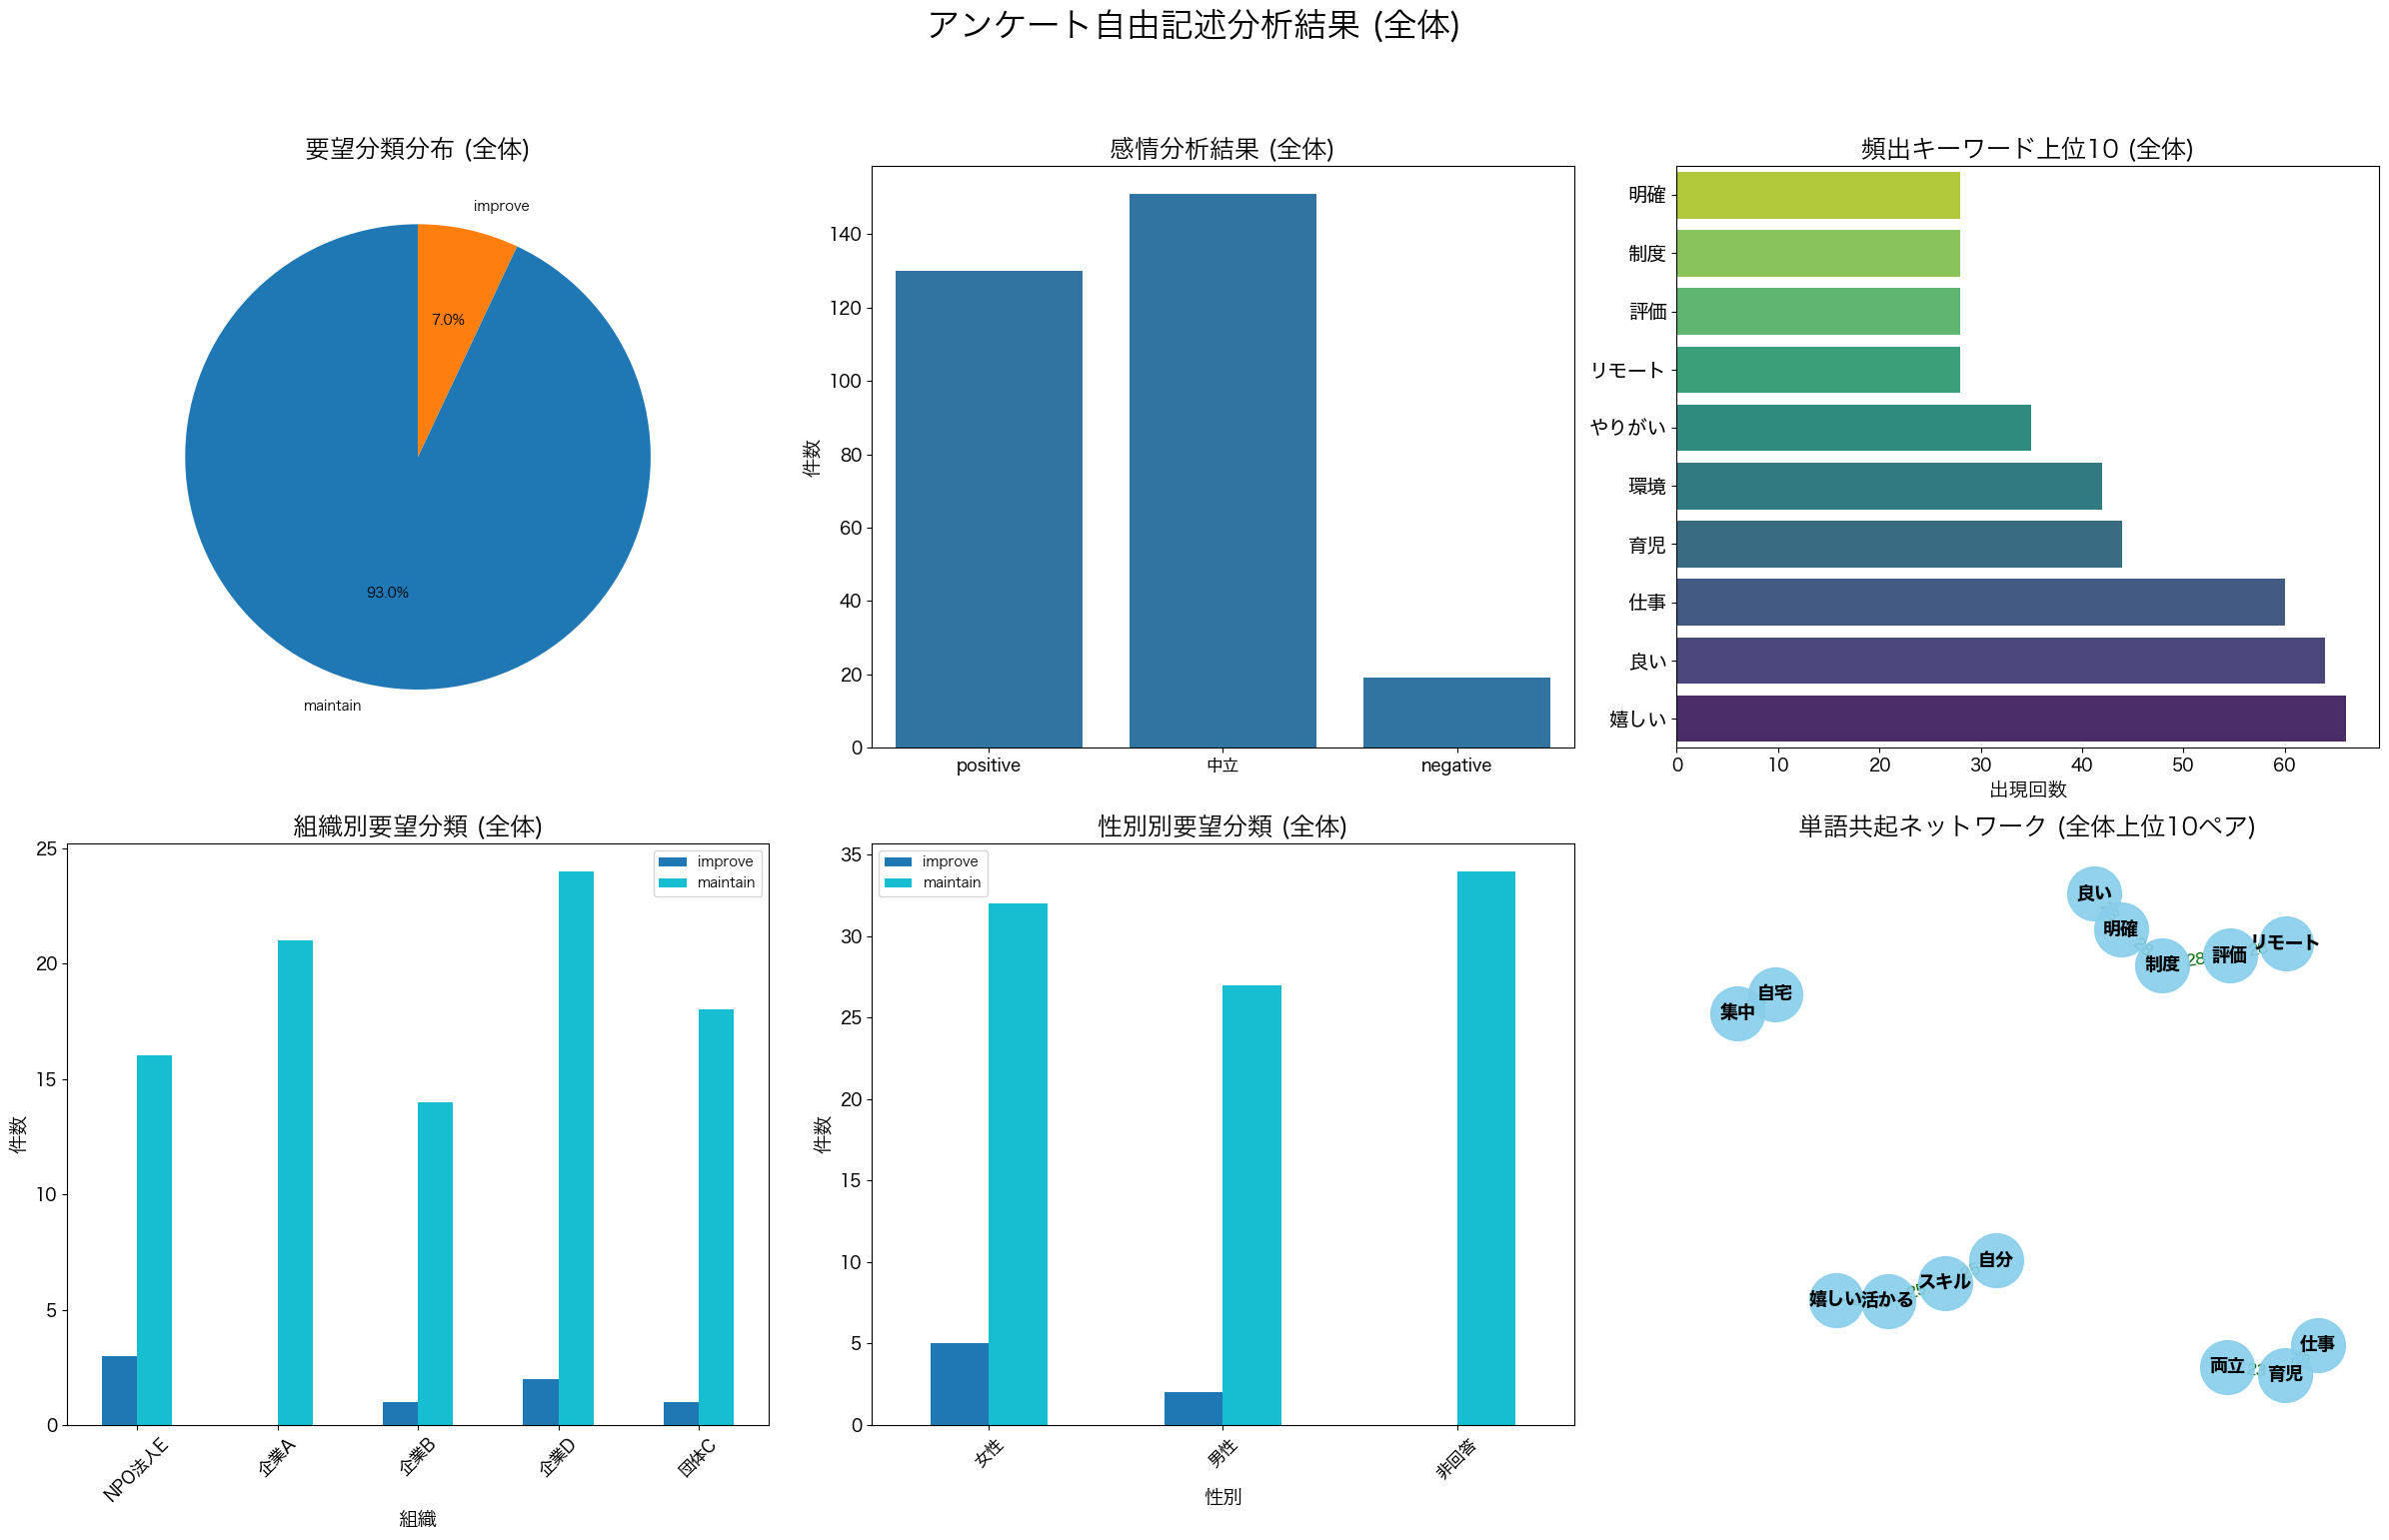

ワードクラウド 'wordcloud_overall.png' を生成しました。
ワードクラウド 'wordcloud_Q1回答.png' を生成しました。
ワードクラウド 'wordcloud_Q2回答.png' を生成しました。
ワードクラウド 'wordcloud_Q3回答.png' を生成しました。


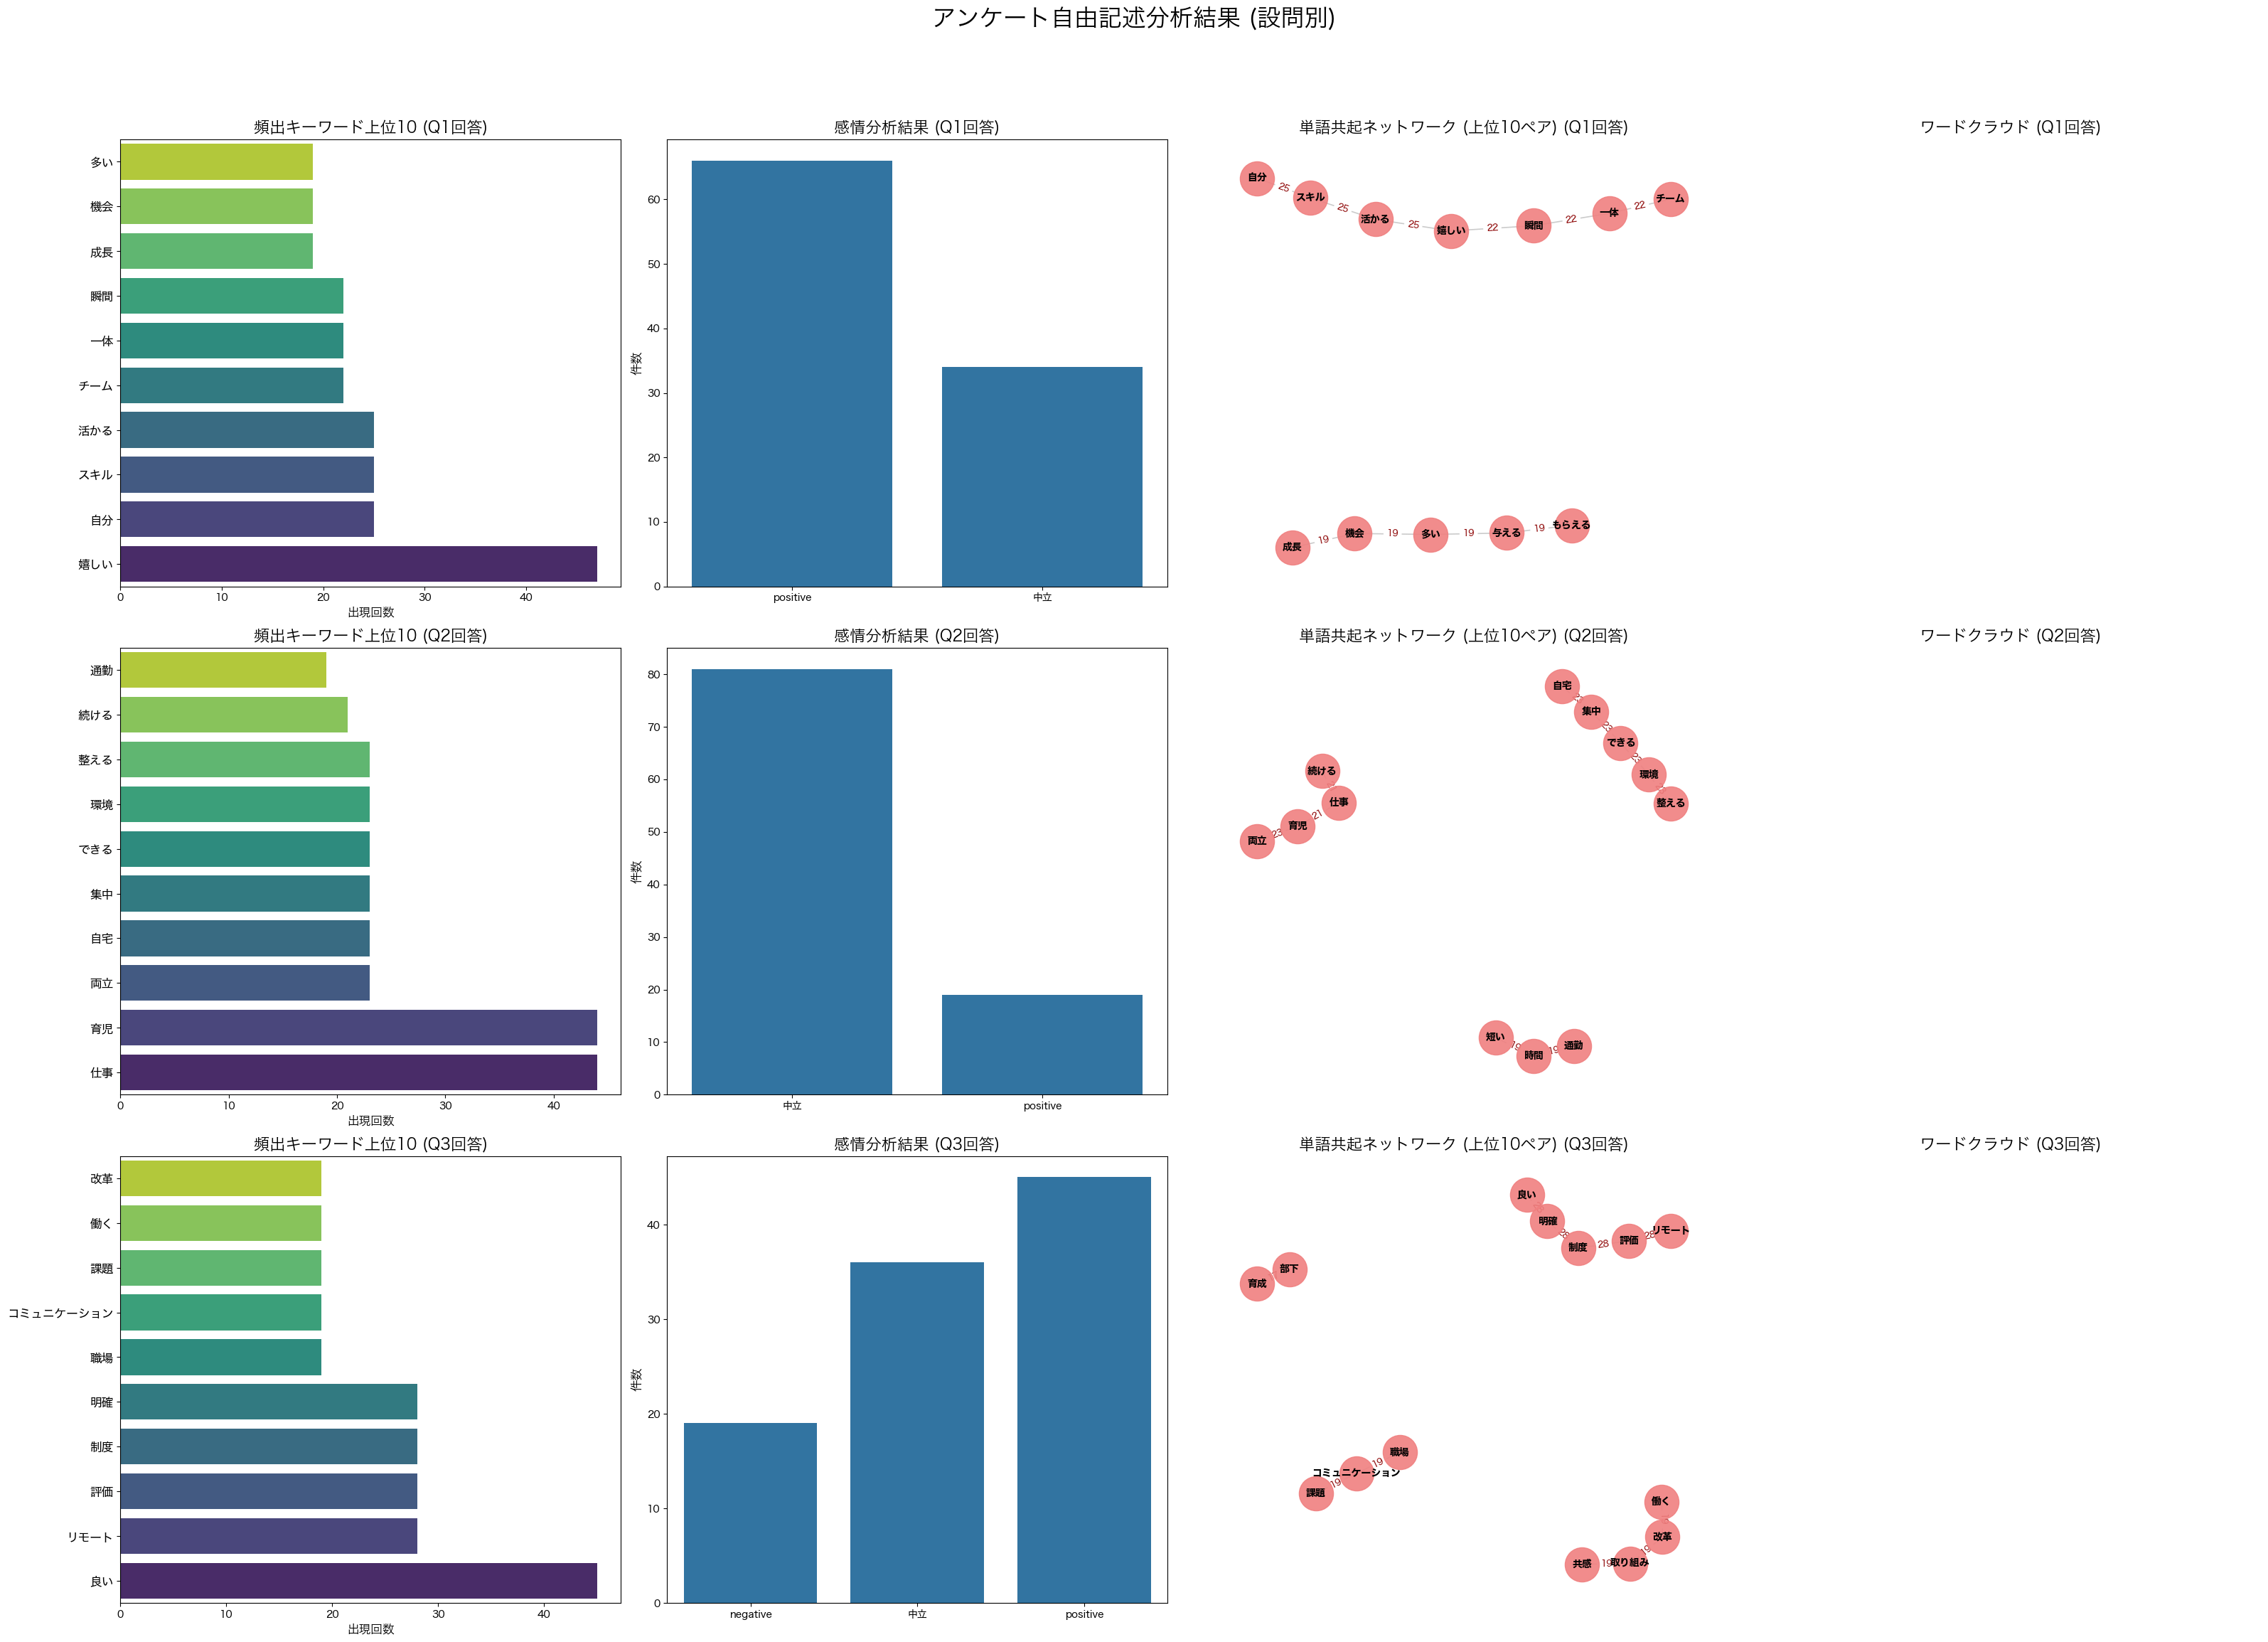

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import platform
import os
from matplotlib import font_manager, rcParams

# WordCloudライブラリをインポート
from wordcloud import WordCloud

# 日本語フォント設定 (再掲)
# WordCloudでもこのフォントパスを使用します
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/meiryo.ttc'
elif platform.system() == 'Darwin':
    font_path = '/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc'
else:
    font_path = '/usr/share/fonts/truetype/vlgothic/VL-Gothic-Regular.ttf'

# font_prop はグローバル変数として保持
font_prop = None
if os.path.exists(font_path):
    font_prop = font_manager.FontProperties(fname=font_path)
    rcParams['font.family'] = font_prop.get_name()
    print(f"日本語フォント '{font_prop.get_name()}' を設定しました。")
else:
    print(f"警告: 指定された日本語フォント '{font_path}' が見つかりません。文字化けの可能性があります。")
    print("利用可能なフォントリスト:")
    font_files = font_manager.findSystemFonts(fontpaths=None)
    found_japanese_font = False
    for f in font_files:
        if "japanese" in f.lower() or "gothic" in f.lower() or "meiryo" in f.lower() or "hiragino" in f.lower() or "noto" in f.lower():
            print(f"- {f}")
            # もし見つかったら、それをfont_pathとして設定し、font_propを初期化
            if font_prop is None: # 最初の見つかったフォントを使用
                font_path = f
                font_prop = font_manager.FontProperties(fname=font_path)
                rcParams['font.family'] = font_prop.get_name()
                print(f"代替日本語フォント '{font_prop.get_name()}' を設定しました。")
                found_japanese_font = True
                break
    if not found_japanese_font:
        print("警告: 代替の日本語フォントも見つかりませんでした。")
        rcParams['font.family'] = ['sans-serif'] # フォールバック

warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from janome.tokenizer import Tokenizer
import re
from itertools import combinations
import json

class SurveyNLPAnalyzer:
    def __init__(self, csv_file_path):
        self.df = pd.read_csv(csv_file_path)
        self.tokenizer = Tokenizer()
        self.processed_data = {}
        self.analysis_results = {}
        self.question_cols = [col for col in self.df.columns if re.match(r'Q\d+回答', col)]

        self.non_specific_patterns = [
            r'わからない', r'特になし', r'不明', r'なし',
            r'特に.*ない', r'よくわからない', r'^\s*$', r'ない'
        ]
        self.excluded_verbs = {'する', 'なる', 'いる', 'られる', '感じる', 'やすい', 'せる', 'ある', 'いう'}
        
        # Word Cloud用のフォントパスをインスタンス変数として保存
        self.wc_font_path = font_path 

    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text_str = str(text).lower()
        for pattern in self.non_specific_patterns:
            if re.search(pattern, text_str):
                return ""
        text_str = re.sub(r'[！!？?。．、，\s\t　]+', ' ', text_str)
        text_str = re.sub(r'[^\wぁ-んァ-ン一-龥a-zA-Z0-9]', '', text_str)
        return text_str.strip()

    def morphological_analysis(self, text):
        if not text:
            return []
        words = []
        for token in self.tokenizer.tokenize(text):
            base_form = token.base_form
            pos = token.part_of_speech.split(',')[0]
            
            if pos in ['名詞', '動詞', '形容詞']:
                if len(base_form) > 1 and base_form not in self.excluded_verbs:
                    words.append(base_form)
        return words

    def extract_keywords_tfidf(self, texts, top_n=10):
        processed_texts_for_vectorizer = [" ".join(self.morphological_analysis(text)) for text in texts if text]
        
        if not processed_texts_for_vectorizer:
            return []
        
        vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=1, max_df=0.8)
        tfidf_matrix = vectorizer.fit_transform(processed_texts_for_vectorizer)
        
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        keywords = [(feature_names[i], scores[i]) for i in range(len(feature_names))]
        return sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]

    def topic_modeling_lda(self, texts, n_topics=5):
        processed_texts_for_vectorizer = [" ".join(self.morphological_analysis(text)) for text in texts if text]

        if len(processed_texts_for_vectorizer) < 2:
            return []
        try:
            vectorizer = TfidfVectorizer(max_features=100, min_df=1, max_df=0.8)
            tfidf_matrix = vectorizer.fit_transform(processed_texts_for_vectorizer)
            
            feature_names = vectorizer.get_feature_names_out()
            lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda.fit(tfidf_matrix)
            topics = []
            for topic_idx, topic in enumerate(lda.components_):
                top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
                topics.append({'topic_id': topic_idx, 'words': top_words, 'weight': topic.max()})
            return topics
        except Exception as e:
            print(f"LDAエラー: {e}")
            return []

    def sentiment_analysis(self, text):
        if not text:
            return {'polarity': 0, 'sentiment': 'neutral'}
        positive_words = ['良い', 'よい', '嬉しい', 'うれしい', '楽しい', '満足', '助かる', '充実']
        negative_words = ['困る', '課題', '不満', '大変', '疲れる', '問題', 'ストレス']
        
        tokens = self.morphological_analysis(text)
        
        pos_count = sum(1 for word in tokens if word in positive_words)
        neg_count = sum(1 for word in tokens if word in negative_words)
        
        if pos_count > neg_count:
            return {'polarity': 1, 'sentiment': 'positive'}
        elif neg_count > pos_count:
            return {'polarity': -1, 'sentiment': 'negative'}
        elif pos_count > 0 and neg_count > 0:
            return {'polarity': 0, 'sentiment': 'ミックス'}
        else:
            return {'polarity': 0, 'sentiment': '中立'}

    def classify_request_type(self, text):
        if not text:
            return 'unknown'
        
        tokens = self.morphological_analysis(text)
        
        maintain_keywords = ['維持', '継続', '現状', '保持', '良い', 'よい', '満足', '嬉しい']
        enhance_keywords = ['強化', '向上', '発展', '拡大', '成長', '進歩', '発達', 'さらに']
        improve_keywords = ['改善', '課題', '問題', '困る', '難しい', '見直し', '変更', '修正']
        
        scores = {
            'maintain': sum(1 for word in tokens if word in maintain_keywords),
            'enhance': sum(1 for word in tokens if word in enhance_keywords),
            'improve': sum(1 for word in tokens if word in improve_keywords)
        }
        
        if all(score == 0 for score in scores.values()):
            return 'maintain'
            
        max_cat = max(scores, key=scores.get)
        return max_cat

    def collocation_analysis(self, texts):
        all_words = []
        for text in texts:
            if text:
                all_words.extend(self.morphological_analysis(text))
        
        if len(all_words) < 2:
            return []
            
        bigrams = [(all_words[i], all_words[i+1]) for i in range(len(all_words) - 1)]
        
        return Counter(bigrams).most_common(10)

    def create_network_graph(self, collocations):
        G = nx.Graph()
        if not collocations:
            return None
        for (w1, w2), count in collocations:
            G.add_edge(w1, w2, weight=count)
        return G if G.number_of_nodes() > 0 else None

    # ワードクラウド生成メソッドの追加
    def generate_wordcloud(self, text_data, file_name, width=800, height=400):
        if not text_data:
            print(f"警告: {file_name} のワードクラウド用のテキストデータが空です。")
            return

        # WordCloudオブジェクトの作成
        # font_pathを指定して日本語を表示可能にする
        wc = WordCloud(
            font_path=self.wc_font_path,
            width=width,
            height=height,
            background_color="white",
            max_words=100, # 表示する単語の最大数
            min_font_size=10, # 最小フォントサイズ
            collocations=False # デフォルトでは共起語も考慮されるが、単語の頻度ベースにする
        )
        
        # スペース区切りのテキストを生成 (Counterオブジェクトも受け付けるが、今回は文字列を渡す)
        word_counts = Counter(self.morphological_analysis(" ".join(text_data)))
        # CounterオブジェクトをWordCloudに渡す方がより正確な頻度を反映できる
        wc.generate_from_frequencies(word_counts)

        # 画像として保存
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(file_name.replace('.png', '').replace('wordcloud_', '').replace('_', ' '), fontproperties=font_prop, fontsize=18)
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        plt.close() # メモリ解放のため閉じる
        print(f"ワードクラウド '{file_name}' を生成しました。")


    def analyze_all_data(self):
        print("=== 自然言語処理分析開始 ===")
        print(f"列名: {self.df.columns.tolist()}")

        all_combined_texts_for_overall_analysis = []
        for col_name in self.question_cols:
            all_combined_texts_for_overall_analysis.extend(self.df[col_name].apply(self.preprocess_text).tolist())
        valid_overall_texts = [text for text in all_combined_texts_for_overall_analysis if text]
        
        print(f"全体での有効回答数: {len(valid_overall_texts)}")

        self.analysis_results['overall'] = {}
        self.analysis_results['overall']['keywords'] = self.extract_keywords_tfidf(valid_overall_texts)
        self.analysis_results['overall']['topics'] = self.topic_modeling_lda(valid_overall_texts)
        
        overall_sentiments = [self.sentiment_analysis(t) for t in valid_overall_texts]
        self.analysis_results['overall']['sentiments'] = Counter([s['sentiment'] for s in overall_sentiments])

        classifications = []
        for i, row in self.df.iterrows():
            combined_text_parts = []
            for col in self.question_cols:
                combined_text_parts.append(self.preprocess_text(row[col]))
            classifications.append(self.classify_request_type(" ".join(combined_text_parts).strip()))

        self.df['classification'] = classifications
        self.analysis_results['overall']['classifications'] = Counter(classifications)
        
        self.analysis_results['overall']['collocations'] = self.collocation_analysis(valid_overall_texts)

        overall_word_counts_list = [] # ワードクラウド用に単語リストを保持
        for text in valid_overall_texts:
            overall_word_counts_list.extend(self.morphological_analysis(text))
        self.analysis_results['overall']['top_words'] = Counter(overall_word_counts_list).most_common(10)
        self.analysis_results['overall']['wordcloud_text'] = overall_word_counts_list # ワードクラウド用

        self.attribute_analysis()

        self.analysis_results['questions'] = {}
        for q_col in self.question_cols:
            print(f"\n--- 設問 '{q_col}' の分析開始 ---")
            q_texts = self.df[q_col].apply(self.preprocess_text).tolist()
            valid_q_texts = [text for text in q_texts if text]
            print(f"設問 '{q_col}' の有効回答数: {len(valid_q_texts)}")

            self.analysis_results['questions'][q_col] = {}
            
            self.analysis_results['questions'][q_col]['keywords'] = self.extract_keywords_tfidf(valid_q_texts)
            
            q_sentiments = [self.sentiment_analysis(t) for t in valid_q_texts]
            self.analysis_results['questions'][q_col]['sentiments'] = Counter([s['sentiment'] for s in q_sentiments])
            
            self.analysis_results['questions'][q_col]['collocations'] = self.collocation_analysis(valid_q_texts)
            
            q_word_counts_list = [] # ワードクラウド用に単語リストを保持
            for text in valid_q_texts:
                q_word_counts_list.extend(self.morphological_analysis(text))
            self.analysis_results['questions'][q_col]['top_words'] = Counter(q_word_counts_list).most_common(10)
            self.analysis_results['questions'][q_col]['wordcloud_text'] = q_word_counts_list # ワードクラウド用

        return self.analysis_results

    def attribute_analysis(self):
        has_org = '組織' in self.df.columns and not self.df['組織'].empty
        has_gender = '性別' in self.df.columns and not self.df['性別'].empty

        if has_org:
            org_analysis = self.df.groupby('組織')['classification'].value_counts().unstack(fill_value=0)
            self.analysis_results['overall']['org_analysis'] = org_analysis
            print("\n--- 組織別要望分類 ---\n", org_analysis)
        else:
            print("\n警告: '組織' 列が見つからないか、データが空です。組織別分析はスキップされます。")
            self.analysis_results['overall']['org_analysis'] = pd.DataFrame()

        if has_gender:
            gender_analysis = self.df.groupby('性別')['classification'].value_counts().unstack(fill_value=0)
            self.analysis_results['overall']['gender_analysis'] = gender_analysis
            print("\n--- 性別別要望分類 ---\n", gender_analysis)
        else:
            print("\n警告: '性別' 列が見つからないか、データが空です。性別別分析はスキップされます。")
            self.analysis_results['overall']['gender_analysis'] = pd.DataFrame()


    def visualize_results(self):
        global font_prop
        if font_prop is None:
            print("警告: 日本語フォントが設定されていないため、一部のテキスト表示が正しくない可能性があります。")
            rcParams['font.family'] = ['sans-serif']

        # --- 全体的な分析結果のグラフ ---
        fig_overall, axes_overall = plt.subplots(2, 3, figsize=(24, 16))
        fig_overall.suptitle('アンケート自由記述分析結果 (全体)', fontproperties=font_prop, fontsize=24, y=0.99)

        # 1. 要望分類分布 (Pie Chart) - 全体
        classification_counts = self.analysis_results['overall'].get('classifications', Counter())
        if classification_counts and any(v > 0 for v in classification_counts.values()):
            labels = [k for k, v in classification_counts.items() if v > 0]
            sizes = [v for k, v in classification_counts.items() if v > 0]
            if font_prop:
                axes_overall[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontproperties': font_prop})
                axes_overall[0, 0].set_title('要望分類分布 (全体)', fontproperties=font_prop, fontsize=18)
            else:
                axes_overall[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                axes_overall[0, 0].set_title('要望分類分布 (全体)', fontsize=18)
        else:
            axes_overall[0, 0].axis('off')
            axes_overall[0, 0].set_title('要望分類データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 2. 感情分析結果 (Bar Chart) - 全体
        sentiment_counts = self.analysis_results['overall'].get('sentiments', Counter())
        if sentiment_counts and any(sentiment_counts.values()):
            sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), ax=axes_overall[0, 1])
            if font_prop:
                axes_overall[0, 1].set_title('感情分析結果 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[0, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=14)
            else:
                axes_overall[0, 1].set_title('感情分析結果 (全体)', fontsize=18)
                axes_overall[0, 1].set_ylabel('件数', fontsize=14)
            axes_overall[0, 1].tick_params(axis='x', labelsize=12)
            axes_overall[0, 1].tick_params(axis='y', labelsize=12)
        else:
            axes_overall[0, 1].axis('off')
            axes_overall[0, 1].set_title('感情分析データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 3. 頻出キーワード上位10 (Horizontal Bar Chart) - 全体
        top_words = self.analysis_results['overall'].get('top_words', [])
        if top_words:
            words, counts = zip(*top_words)
            sns.barplot(x=list(counts), y=list(words), ax=axes_overall[0, 2], orient='h', palette='viridis')
            if font_prop:
                axes_overall[0, 2].set_title('頻出キーワード上位10 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[0, 2].set_xlabel('出現回数', fontproperties=font_prop, fontsize=14)
            else:
                axes_overall[0, 2].set_title('頻出キーワード上位10 (全体)', fontsize=18)
                axes_overall[0, 2].set_xlabel('出現回数', fontsize=14)
            axes_overall[0, 2].tick_params(axis='y', labelsize=14)
            axes_overall[0, 2].tick_params(axis='x', labelsize=12)
            axes_overall[0, 2].invert_yaxis()
        else:
            axes_overall[0, 2].axis('off')
            axes_overall[0, 2].set_title('頻出キーワードなし (全体)', fontproperties=font_prop, fontsize=18)

        # 4. 組織別要望分類 (Bar Chart) - 全体
        org_analysis = self.analysis_results['overall'].get('org_analysis', pd.DataFrame())
        if not org_analysis.empty and not org_analysis.sum().sum() == 0:
            org_analysis.plot(kind='bar', ax=axes_overall[1, 0], colormap='tab10')
            if font_prop:
                axes_overall[1, 0].set_title('組織別要望分類 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[1, 0].set_ylabel('件数', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 0].set_xlabel('組織', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 0].legend(prop=font_prop, fontsize=12)
            else:
                axes_overall[1, 0].set_title('組織別要望分類 (全体)', fontsize=18)
                axes_overall[1, 0].set_ylabel('件数', fontsize=14)
                axes_overall[1, 0].set_xlabel('組織', fontsize=14)
                axes_overall[1, 0].legend(fontsize=12)
            axes_overall[1, 0].tick_params(axis='x', rotation=45, labelsize=12)
            axes_overall[1, 0].tick_params(axis='y', labelsize=12)
        else:
            axes_overall[1, 0].axis('off')
            axes_overall[1, 0].set_title('組織別分類データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 5. 性別別要望分類 (Bar Chart) - 全体
        gender_analysis = self.analysis_results['overall'].get('gender_analysis', pd.DataFrame())
        if not gender_analysis.empty and not gender_analysis.sum().sum() == 0:
            gender_analysis.plot(kind='bar', ax=axes_overall[1, 1], colormap='tab10')
            if font_prop:
                axes_overall[1, 1].set_title('性別別要望分類 (全体)', fontproperties=font_prop, fontsize=18)
                axes_overall[1, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 1].set_xlabel('性別', fontproperties=font_prop, fontsize=14)
                axes_overall[1, 1].legend(prop=font_prop, fontsize=12)
            else:
                axes_overall[1, 1].set_title('性別別要望分類 (全体)', fontsize=18)
                axes_overall[1, 1].set_ylabel('件数', fontsize=14)
                axes_overall[1, 1].set_xlabel('性別', fontsize=14)
                axes_overall[1, 1].legend(fontsize=12)
            axes_overall[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
            axes_overall[1, 1].tick_params(axis='y', labelsize=12)
        else:
            axes_overall[1, 1].axis('off')
            axes_overall[1, 1].set_title('性別分類データなし (全体)', fontproperties=font_prop, fontsize=18)

        # 6. 単語共起ネットワーク (Network Graph) - 全体
        collocations_overall = self.analysis_results['overall'].get('collocations', [])
        G_overall = self.create_network_graph(collocations_overall[:10])
        if G_overall:
            pos_overall = nx.spring_layout(G_overall, k=0.8, iterations=50, seed=42)
            nx.draw_networkx_nodes(G_overall, pos_overall, ax=axes_overall[1, 2], node_color='skyblue', node_size=1500, alpha=0.9)
            nx.draw_networkx_edges(G_overall, pos_overall, ax=axes_overall[1, 2], width=1.5, alpha=0.7, edge_color='gray')
            edge_labels_overall = nx.get_edge_attributes(G_overall, 'weight')
            if font_prop:
                nx.draw_networkx_edge_labels(G_overall, pos_overall, edge_labels=edge_labels_overall, ax=axes_overall[1, 2], font_size=11, font_color='darkgreen', font_family=font_prop.get_name())
                nx.draw_networkx_labels(G_overall, pos_overall, ax=axes_overall[1, 2], font_size=13, font_weight='bold', font_color='black', font_family=font_prop.get_name())
                axes_overall[1, 2].set_title('単語共起ネットワーク (全体上位10ペア)', fontproperties=font_prop, fontsize=18)
            else:
                nx.draw_networkx_edge_labels(G_overall, pos_overall, edge_labels=edge_labels_overall, ax=axes_overall[1, 2], font_size=11, font_color='darkgreen')
                nx.draw_networkx_labels(G_overall, pos_overall, ax=axes_overall[1, 2], font_size=13, font_weight='bold', font_color='black')
                axes_overall[1, 2].set_title('単語共起ネットワーク (全体上位10ペア)', fontsize=18)
            axes_overall[1, 2].axis('off')
        else:
            axes_overall[1, 2].axis('off')
            axes_overall[1, 2].set_title('共起データなし (全体)', fontproperties=font_prop, fontsize=18)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('survey_analysis_results_overall.png', dpi=300, bbox_inches='tight')
        plt.show()

        # ワードクラウドの生成 (全体)
        overall_wc_text = self.analysis_results['overall'].get('wordcloud_text', [])
        self.generate_wordcloud(overall_wc_text, 'wordcloud_overall.png', width=1200, height=600)

        # --- 各設問ごとのグラフ ---
        # グラフを既存の3種類 + ワードクラウド1種類 = 4種類 に増やす
        # レイアウトを num_questions x 4 に変更
        num_questions = len(self.question_cols)
        fig_questions, axes_questions = plt.subplots(num_questions, 4, figsize=(32, 8 * num_questions)) # 各行の幅を調整
        fig_questions.suptitle('アンケート自由記述分析結果 (設問別)', fontproperties=font_prop, fontsize=24, y=0.99)
        
        if num_questions == 1:
            axes_questions = np.array([axes_questions]) # 常に2次元配列として扱う

        for i, q_col in enumerate(self.question_cols):
            q_results = self.analysis_results['questions'][q_col]
            
            # 1. 頻出キーワード上位10 (Horizontal Bar Chart) - 設問別
            q_top_words = q_results.get('top_words', [])
            if q_top_words:
                words, counts = zip(*q_top_words)
                sns.barplot(x=list(counts), y=list(words), ax=axes_questions[i, 0], orient='h', palette='viridis')
                if font_prop:
                    axes_questions[i, 0].set_title(f'頻出キーワード上位10 ({q_col})', fontproperties=font_prop, fontsize=16)
                    axes_questions[i, 0].set_xlabel('出現回数', fontproperties=font_prop, fontsize=12)
                else:
                    axes_questions[i, 0].set_title(f'頻出キーワード上位10 ({q_col})', fontsize=16)
                    axes_questions[i, 0].set_xlabel('出現回数', fontsize=12)
                axes_questions[i, 0].tick_params(axis='y', labelsize=12)
                axes_questions[i, 0].tick_params(axis='x', labelsize=10)
                axes_questions[i, 0].invert_yaxis()
            else:
                axes_questions[i, 0].axis('off')
                axes_questions[i, 0].set_title(f'頻出キーワードなし ({q_col})', fontproperties=font_prop, fontsize=16)

            # 2. 感情分析結果 (Bar Chart) - 設問別
            q_sentiment_counts = q_results.get('sentiments', Counter())
            if q_sentiment_counts and any(q_sentiment_counts.values()):
                sns.barplot(x=list(q_sentiment_counts.keys()), y=list(q_sentiment_counts.values()), ax=axes_questions[i, 1])
                if font_prop:
                    axes_questions[i, 1].set_title(f'感情分析結果 ({q_col})', fontproperties=font_prop, fontsize=16)
                    axes_questions[i, 1].set_ylabel('件数', fontproperties=font_prop, fontsize=12)
                else:
                    axes_questions[i, 1].set_title(f'感情分析結果 ({q_col})', fontsize=16)
                    axes_questions[i, 1].set_ylabel('件数', fontsize=12)
                axes_questions[i, 1].tick_params(axis='x', labelsize=10)
                axes_questions[i, 1].tick_params(axis='y', labelsize=10)
            else:
                axes_questions[i, 1].axis('off')
                axes_questions[i, 1].set_title(f'感情分析データなし ({q_col})', fontproperties=font_prop, fontsize=16)

            # 3. 単語共起ネットワーク (Network Graph) - 設問別
            q_collocations = q_results.get('collocations', [])
            G_q = self.create_network_graph(q_collocations[:10])
            if G_q:
                pos_q = nx.spring_layout(G_q, k=0.8, iterations=50, seed=42)
                nx.draw_networkx_nodes(G_q, pos_q, ax=axes_questions[i, 2], node_color='lightcoral', node_size=1200, alpha=0.9)
                nx.draw_networkx_edges(G_q, pos_q, ax=axes_questions[i, 2], width=1.2, alpha=0.6, edge_color='darkgray')
                edge_labels_q = nx.get_edge_attributes(G_q, 'weight')
                if font_prop:
                    nx.draw_networkx_edge_labels(G_q, pos_q, edge_labels=edge_labels_q, ax=axes_questions[i, 2], font_size=9, font_color='darkred', font_family=font_prop.get_name())
                    nx.draw_networkx_labels(G_q, pos_q, ax=axes_questions[i, 2], font_size=10, font_weight='bold', font_color='black', font_family=font_prop.get_name())
                    axes_questions[i, 2].set_title(f'単語共起ネットワーク (上位10ペア) ({q_col})', fontproperties=font_prop, fontsize=16)
                else:
                    nx.draw_networkx_edge_labels(G_q, pos_q, edge_labels=edge_labels_q, ax=axes_questions[i, 2], font_size=9, font_color='darkred')
                    nx.draw_networkx_labels(G_q, pos_q, ax=axes_questions[i, 2], font_size=10, font_weight='bold', font_color='black')
                    axes_questions[i, 2].set_title(f'単語共起ネットワーク (上位10ペア) ({q_col})', fontsize=16)
                axes_questions[i, 2].axis('off')
            else:
                axes_questions[i, 2].axis('off')
                axes_questions[i, 2].set_title(f'共起データなし ({q_col})', fontproperties=font_prop, fontsize=16)
            
            # 4. ワードクラウド - 設問別 (直接 axes に描画するのではなく、個別にファイルを生成)
            q_wc_text = q_results.get('wordcloud_text', [])
            # axes_questions[i, 3] を直接使用せず、別途generate_wordcloudを呼び出し、画像ファイルとして保存
            self.generate_wordcloud(q_wc_text, f'wordcloud_{q_col}.png', width=800, height=400)
            
            # ワードクラウドを直接サブプロットに表示する場合（現在の実装ではファイルを生成して保存する）
            # もしサブプロットに直接ワードクラウドを表示したい場合は、WordCloudをgenerateしてplt.imshowを呼ぶ
            # ただし、WordCloudのオブジェクト生成と画像生成には時間がかかるため、ファイルとして保存する方が効率的
            # ここでは便宜的にサブプロットをオフにする
            axes_questions[i, 3].axis('off')
            if font_prop:
                axes_questions[i, 3].set_title(f'ワードクラウド ({q_col})', fontproperties=font_prop, fontsize=16)
            else:
                axes_questions[i, 3].set_title(f'ワードクラウド ({q_col})', fontsize=16)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('survey_analysis_results_questions.png', dpi=300, bbox_inches='tight')
        plt.show()


def main():
    analyzer = SurveyNLPAnalyzer('random_survey_output_bom.csv')
    analyzer.analyze_all_data()
    analyzer.visualize_results()

if __name__ == '__main__':
    main()

2025-07-12 11:40:50.839 No runtime found, using MemoryCacheStorageManager
2025-07-12 11:40:50.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 11:40:50.864 Thread 'MainThread':